In [1]:
# Importing necessary modules

import sklearn.datasets as datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
newline = "\n"
max_tolerate_entropy = 0

In [2]:
import pandas as pd 
# read text file into pandas DataFrame and 
# create header 
import os
Column_names = ["TIME_str", "TIME_sec", "latitude", "longitude", "ALTITUDE_FT", "GRD_TRK", "GRD_SPD", "VTC_SPD", \
             "Vertical_label","Horizontal_label", "Speed_label",\
            "TURN_RATE", "REL_HEADING", "DIS_TO_DES", "MANEUVER_ID" ]
Selected_col_names = ["GRD_SPD", "VTC_SPD", "DIS_TO_DES"]
Target_category_name = "Vertical_label"
data_name = "HOLD_3"
cwd = os.getcwd()
mypath = cwd + f"/../data/{data_name}/"
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [3]:
count = 0

for file_name in onlyfiles:
    if "Traj" in file_name:
        if count == 0:
            file_path = mypath + file_name
            df = pd.read_csv(file_path, sep=",", header=None)
            df.columns = Column_names
            X_df = df[Selected_col_names]
            Y_target = df[Target_category_name]
        else:
            file_path = mypath + file_name
            df_temp = pd.read_csv(file_path, sep=",", header=None)
            df_temp.columns = Column_names
            
            X_df_temp = df_temp[Selected_col_names]
            Y_target_temp = df_temp[Target_category_name]
            X_df = pd.concat([X_df, X_df_temp],ignore_index=True)
            Y_target = pd.concat([Y_target, Y_target_temp])
        count +=1
        # if count >= 10:
        #     break

In [4]:
target_names =  list(set(list(Y_target)))
word_map_to_num = set(list(Y_target))
print("category:")
word_map_to_num


category:


{'  Over 250 kts under 10000ft',
 ' Climb_Nominal',
 ' Descend_Nominal',
 ' MaintainCurrentAltitude',
 ' No Conclusion: Vertical'}

In [5]:
n_sample = len(X_df)
print("number of points:", n_sample)
X_df = X_df.head(n_sample)
Y_target = Y_target.head(n_sample)
Y = []
for y in Y_target:
    for idx, s in enumerate(word_map_to_num):
        if s == y:
            Y.append(idx)
Y = np.array(Y)

number of points: 54570


In [6]:
X_df

,GRD_SPD,VTC_SPD,DIS_TO_DES
0,478.0,-960.0,158.983083
1,478.0,-960.0,158.850864
2,478.0,-1024.0,158.705733
3,478.0,-1024.0,158.573513
4,478.0,-1024.0,158.441294
...,...,...,...
54565,254.0,-640.0,0.070556
54566,254.0,-640.0,0.070556
54567,254.0,-640.0,0.070556
54568,254.0,-640.0,0.070556


In [7]:
import pandas as pd 
import dtreeviz
from sklearn.tree import export_text
# read text file into pandas DataFrame and 
# create header 
import os
cwd = os.getcwd()

# file_name_test = "Traj_AAL80-11121269.dat" # worst
file_name_test = "Traj_AAL245-11147798_L_HOLD.dat" # normal

file_path_test = mypath + file_name_test


# file_name_test = "Traj_AAL1252-11172342POS_HOLD.dat"

# file_path_test = cwd + "/../data/HOLD/" + file_name_test


df_test = pd.read_csv(file_path_test, sep=",", header=None)
df_test.columns = Column_names
X_df_test = df_test[Selected_col_names]

In [8]:
print("number of testing points:", len(X_df_test))

number of testing points: 3407


In [9]:
Z_target = df_test[Target_category_name]
test_sample = len(X_df_test)
X_df_test = X_df_test.head(test_sample)
Z_target = Z_target.head(test_sample)
Z = []
for z in Z_target:
    for idx, s in enumerate(word_map_to_num):
        if s == z:
            Z.append(idx)
Z = np.array(Z)
len(Z)
print_for_rf = True

## target 1: vertical_label

# Entropy

In [10]:
vocabulary = {
    "GRD_SPD": ["very low", "low", "normal", "high", "very high"],
    "VTC_SPD": ["UGTDesc","OffNomDesc", "NomDesc", "NoClimb", "NomClimb","OffNomClimb", "UGTClimb"],
    "TURN_RATE": ["very low", "low", "normal", "high", "very high"],
    "REL_HEADING": ["extremely left", "left", "straight", "right", "extremely right"],
    "DIS_TO_DES": ["very close", "close", "a little far", "far", "very far"]
}
pre_def_ranges = {
    "VTC_SPD": [-2500, -2100, -1800, 0, 1650, 1800, 1950],

}
# five words needs 4 landmarks
# seperate equally

In [11]:
from sklearn.tree import export_text_in_words
from sklearn.utils.validation import check_array , check_is_fitted
from sklearn.base import is_classifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, _criterion, _tree
import matplotlib.pyplot as plt
def compute_entropy(value):
    rtn = 0
    tot = np.sum(value)
    probs = [v/tot for v in value]
    for p in probs:
        if p>= 0.001:
            rtn += - p * np.log(p)
    return rtn
        
def export_text_for_main_reasons(
        X_df,
        decision_tree,
        *,
        feature_names=None,
        class_names=None,
        max_depth=10,
        spacing=3,
        decimals=2,
        show_weights=False,
        show_prob = True,
        crn_threshold = 0.1
):

    import copy
    threshold_collection = dict()
    if feature_names is not None:
        feature_names = check_array(
            feature_names, ensure_2d=False, dtype=None, ensure_min_samples=0
        )
    if class_names is not None:
        class_names = check_array(
            class_names, ensure_2d=False, dtype=None, ensure_min_samples=0
        )

    check_is_fitted(decision_tree)
    tree_ = decision_tree.tree_
    if is_classifier(decision_tree):
        if class_names is None:
            class_names = decision_tree.classes_
        elif len(class_names) != len(decision_tree.classes_):
            raise ValueError(
                "When `class_names` is an array, it should contain as"
                " many items as `decision_tree.classes_`. Got"
                f" {len(class_names)} while the tree was fitted with"
                f" {len(decision_tree.classes_)} classes."
            )
    right_child_fmt = "{} {} is {}"
    left_child_fmt = "{} {} is {}"
    truncation_fmt = "{} {}\n"

    if feature_names is not None and len(feature_names) != tree_.n_features:
        raise ValueError(
            "feature_names must contain %d elements, got %d"
            % (tree_.n_features, len(feature_names))
        )

    if isinstance(decision_tree, DecisionTreeClassifier):
        value_fmt = "{}{} weights: {}\n"
        if not show_weights:
            value_fmt = "{}{}{}\n"
    else:
        value_fmt = "{}{} value: {}\n"

    if feature_names is not None:
        feature_names_ = [
            feature_names[i] if i != _tree.TREE_UNDEFINED else None
            for i in tree_.feature
        ]
    else:
        feature_names_ = ["feature_{}".format(i) for i in tree_.feature]

    export_text.report = ""

    def _add_leaf(node_id, value, class_name, indent, lower_bound_dict, upper_bound_dict, printable):
        ## estiblish upper and lower dict for the features, upper collection the upper value, right child of the threshold, keep decreasing
        # lower_bound_dict collect the lower value, left child of the threshold, keep increasing
        #     right_child_fmt = "{} {} <= {}" left and right children are not corresponding to the graph, this is only for the tree,
        #     left_child_fmt = "{} {} > {}" the tree is build from right small to left big
        val = ""
        is_classification = isinstance(decision_tree, DecisionTreeClassifier)
        if show_weights or not is_classification:
            val = ["{1:.{0}f}, ".format(decimals, v) for v in value]
            val = "[" + "".join(val)[:-2] + "]"
        if is_classification:
            val += " class: " + str(class_name)
        export_text.report += value_fmt.format(indent, "", val)

        ##
        if printable:
            output_conditions = []
            all_feature_names = set(list(lower_bound_dict.keys()) + list(upper_bound_dict.keys()))
            for key in all_feature_names:
                cur_vocabulary = vocabulary[key]
                interval_length = interval_length_collection[key]
                cur_list = threshold_collection[key]
                cur_words = []
                if (key in lower_bound_dict.keys()) and (key in upper_bound_dict.keys()):
                    for idx in range(len(cur_vocabulary)-1):
                        left_range, right_range = cur_list[interval_length*idx], cur_list[interval_length*(idx+1)]
                        if left_range <= lower_bound_dict[key] <= right_range or left_range <= upper_bound_dict[key] <= right_range:
                            cur_words.append(cur_vocabulary[idx])
                    right_range = cur_list[interval_length*(idx+1)]
                    if lower_bound_dict[key] >= right_range or upper_bound_dict[key] >= right_range:
                        cur_words.append(cur_vocabulary[-1])
                    cur_range_txt = f"(around {lower_bound_dict[key]:.02f} ~ {upper_bound_dict[key]:.02f})"
                    cur_condition = f"{key} is " + " or ".join(cur_words) + cur_range_txt
                    output_conditions.append(cur_condition)
                    
                elif (key in lower_bound_dict.keys()):
                    for idx in range(len(cur_vocabulary)-1):
                        left_range, right_range = cur_list[interval_length*idx], cur_list[interval_length*(idx+1)]
                        if left_range <= lower_bound_dict[key] <= right_range:
                            cur_words.append(cur_vocabulary[idx])
                    right_range = cur_list[interval_length*(idx+1)]
                    if lower_bound_dict[key] >= right_range:
                        cur_words.append(cur_vocabulary[-1])
                    cur_range_txt = f"(> {lower_bound_dict[key]:.02f})"
                    cur_condition = f"{key} is " + " or ".join(cur_words) + cur_range_txt
                    output_conditions.append(cur_condition)

                elif (key in upper_bound_dict.keys()):
                    for idx in range(len(cur_vocabulary)-1):
                        left_range, right_range = cur_list[interval_length*idx], cur_list[interval_length*(idx+1)]
                        if left_range <= upper_bound_dict[key] <= right_range:
                            cur_words.append(cur_vocabulary[idx])
                    right_range = cur_list[interval_length*(idx+1)]
                    if upper_bound_dict[key] >= right_range:
                        cur_words.append(cur_vocabulary[-1])
                    cur_range_txt = f"(<= {upper_bound_dict[key]:.02f})"
                    cur_condition = f"{key} is " + " or ".join(cur_words) + cur_range_txt
                    output_conditions.append(cur_condition)
            entropy = compute_entropy(value)
            cur_number_of_node = np.sum(value)

            CRN = entropy + (1 - cur_number_of_node/n_sample)
            prob = np.max(value)/np.sum(value)*100
            output_rst = "Class: " + f"{str(class_name)}." + newline
            output_conds = ""
            for idx, cdn in enumerate(output_conditions):
                if idx != len(output_conditions)-1:
                    output_conds += cdn + "," + newline
                else:
                    output_conds += cdn + "." + newline
            output_reasons = f"CRN: {CRN:.2f}," + newline
            output_reasons += f"Prob(Purity): {prob:.2f}," + newline
            output_reasons += f"Number: {int(cur_number_of_node)}." + newline
            if CRN < crn_threshold:
                global max_tolerate_entropy
                # update max_tolerate_entropy
                if max_tolerate_entropy < entropy:
                    max_tolerate_entropy = entropy
                final_output = output_rst + output_conds + output_reasons
                leaf_explainations[node_id] = final_output
                global print_for_rf
                if not print_for_rf:
                    print(final_output)
                    print()
    def print_tree_recurse(node, depth, lower_bound_dict, upper_bound_dict, printable):
        indent = ""

        value = None
        if tree_.n_outputs == 1:
            value = tree_.value[node][0]
        else:
            value = tree_.value[node].T[0]
        class_name = np.argmax(value)

        if tree_.n_classes[0] != 1 and tree_.n_outputs == 1:
            class_name = class_names[class_name]

        if depth <= max_depth + 1:
            info_fmt = ""
            info_fmt_left = info_fmt
            info_fmt_right = info_fmt

            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                name = feature_names_[node] # the name of the feature in string
                threshold = tree_.threshold[node] # the value of the threshold
                # threshold = "{1:.{0}f}".format(decimals, threshold)
                if not printable:
                    if name not in threshold_collection:
                        threshold_collection[name] = []
                    else:
                        threshold_collection[name].append(threshold)


                # print_tree_recurse(tree_.children_left[node], depth + 1, cur_pre_text + right_child_fmt.format(indent, name, threshold) )
                # print the less than case, right_child_fmt is corresponding to the <= case.
                changed_upper_bound_dict = copy.deepcopy(upper_bound_dict)
                changed_upper_bound_dict[name]= threshold
                print_tree_recurse(tree_.children_left[node], depth + 1, lower_bound_dict, changed_upper_bound_dict, printable)

                changed_lower_bound_dict = copy.deepcopy(lower_bound_dict)
                changed_lower_bound_dict[name]=threshold
                print_tree_recurse(tree_.children_right[node], depth + 1, changed_lower_bound_dict, upper_bound_dict, printable)
            else:  # leaf
                _add_leaf(node, value, class_name, indent, lower_bound_dict, upper_bound_dict, printable)
        else:
            subtree_depth = _compute_depth(tree_, node)
            if subtree_depth == 1:
                _add_leaf(node, value, class_name, indent)
            else:
                trunc_report = "truncated branch of depth %d" % subtree_depth
                export_text.report += truncation_fmt.format(indent, trunc_report)

    upper_bound_dict = dict()
    lower_bound_dict = dict()
    # construct the threshold_collection
    print_tree_recurse(0, 1, lower_bound_dict, upper_bound_dict, printable = False)
    # print the range of levels for each feature
    interval_length_collection = dict()
    for feature_name in Selected_col_names:
        threshold_collection[feature_name].sort()

        cur_list = threshold_collection[feature_name]
        cur_vocal = vocabulary[feature_name]
        interval_length = (len(cur_list)-1) // (len(cur_vocal)-1)
        interval_length_collection[feature_name] = interval_length
        # threshold_collection[0:intervals_length] is the first level
        # threshold_collection[intervals_length:2*intervals_length] is the second level
        # ...
        if feature_name in pre_def_ranges:
            threshold_collection[feature_name] = pre_def_ranges[feature_name]
            interval_length = 1
            interval_length_collection[feature_name] = interval_length
            cur_list = threshold_collection[feature_name]
        else:
            pre_def_ranges[feature_name] = [cur_list[interval_length*i] for i in range(len(cur_vocal))]
        global print_for_rf
        if not print_for_rf:
            print(f"###########################################")
            print(f"{r'feature name':^20} : {feature_name}")
            print(f"{r'number of ranges':^20} : {len(cur_vocal)}")
            print(f"-------------------------------------------")
            for i in range(len(cur_vocal)-1):
                left_range = cur_list[interval_length*i]
                right_range = cur_list[interval_length*(i+1)]
                
                print(f"{cur_vocal[i]:^20} : [{left_range:.2f},{right_range:.2f}]")
            right_range = cur_list[interval_length*(i+1)]
            print(f"{cur_vocal[-1]:^20} :  >= {right_range:.2f}")
    if not print_for_rf:
        print(f"###########################################")
    upper_bound_dict = dict()
    lower_bound_dict = dict()
    print_tree_recurse(0, 1, lower_bound_dict, upper_bound_dict, printable = True)

    return export_text.report

In [12]:
import os
import tempfile
from typing import Mapping, List, Callable

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from colour import Color, rgb2hex
from sklearn import tree

from dtreeviz.colors import adjust_colors
from dtreeviz.interpretation import explain_prediction_plain_english, explain_prediction_sklearn_default
from dtreeviz.models.shadow_decision_tree import ShadowDecTree
from dtreeviz.models.shadow_decision_tree import ShadowDecTreeNode
from dtreeviz.utils import myround, DTreeVizRender, add_classifier_legend, _format_axes, _draw_wedge, \
                           _set_wedge_ticks, tessellate, is_numeric

# How many bins should we have based upon number of classes
NUM_BINS = [
    0, 0, 10, 9, 8, 6,
    6, 6, 5, 5, 5, 5,
    5, 5, 5, 5, 5, 5,
    5, 5, 5, 5, 5, 5,
    5, 5, 5, 5, 5, 5,
    5, 5, 5, 5, 5, 5,
    5, 5, 5, 5, 5,
]  # support for 40 classes


class DTreeVizAPI:
    """
    This object provides the primary interface to the functionality of this library. You can think of it as
    an adaptor that adapts the various decision-tree based libraries for use with dtreeviz. In implementation,
    however, this object encapsulates the key functionality and API but delegates tree model adaptation
    from sklearn etc... to dtreeviz.models.ShadowDecTree subclasses.
    """
    def __init__(self, shahdow_tree: ShadowDecTree):
        self.shadow_tree = shahdow_tree

    def leaf_sizes(self,
                   display_type: str = "plot",
                   colors: dict = None,
                   fontsize: int = 10,
                   fontname: str = "Arial",
                   grid: bool = False,
                   bins: int = 10,
                   min_size: int = 0,
                   max_size: int = None,
                   figsize: tuple = None,
                   ax=None):
        """Visualize leaf sizes.

        Interpreting leaf sizes can help us to see how the data is spread over the tree:
        - if we have a leaf with many samples and a good purity, it means that we can be pretty confident
        on its prediction.
        - if we have a leaf with few samples and a good purity, we cannot be very confident on its prediction and
        it could be a sign of overfitting.
        - by visualizing leaf sizes, we can easily discover important leaves . Using node_stats() function we
        can take all of its samples and discover common patterns between leaf samples.
        - if the tree contains a lot of leaves and we want a general overview about leaves sizes, we can use the
        parameter display_type='hist' to display the histogram of leaf sizes.

        There is the option to filter the leaves with sizes between 'min_size' and 'max_size'. This is helpful
        especially when you want to investigate leaves with sizes from a specific range.

        This method contains three types of visualizations:
        - If display_type = 'plot' it will show leaf sizes using a plot.
        - If display_type = 'text' it will show leaf sizes as plain text. This method is preferred if number
        of leaves is very large and the plot become very big and hard to interpret.
        - If display_type = 'hist' it will show leaf size histogram. Useful when you want to easily see the general
        distribution of leaf sizes.

        Usage example :
        viz_model = dtreeviz.model(tree_model, X_train=dataset[features], y_train=dataset[target],
                                   feature_names=features, target_name=target, class_names=[0, 1])
        viz_model.leaf_sizes()

        :param display_type: str, optional
           'plot', 'text'. 'hist'
        :param colors: dict
            The set of colors used for plotting
        :param fontsize: int
            Plot labels font size
        :param fontname: str
            Plot labels font name
        :param grid: bool
            True if we want to display the grid lines on the visualization
        :param bins: int
            Number of histogram bins
        :param min_size: int
            Min size for a leaf
        :param max_size: int
            Max size for a leaf
        :param figsize: optional (width, height) in inches for the entire plot
            :param ax: optional matplotlib "axes" to draw into
        """
        leaf_id, leaf_sizes = self.shadow_tree.get_leaf_sample_counts(min_size, max_size)

        if display_type == "text":
            for leaf, samples in zip(leaf_id, leaf_sizes):
                print(f"leaf {leaf} has {samples} samples")
        elif display_type in ["plot", "hist"]:
            colors = adjust_colors(colors)
            if ax is None:
                if figsize:
                    fig, ax = plt.subplots(figsize=figsize)
                else:
                    fig, ax = plt.subplots()
        else:
            raise ValueError(f'Unknown display_type = {display_type}')

        if display_type == "plot":
            ax.set_xticks(range(0, len(leaf_id)))
            ax.set_xticklabels(leaf_id)
            barcontainers = ax.bar(range(0, len(leaf_id)), leaf_sizes, color=colors["hist_bar"], lw=.3,
                                   align='center',
                                   width=1)
            for rect in barcontainers.patches:
                rect.set_linewidth(.5)
                rect.set_edgecolor(colors['rect_edge'])

            _format_axes(ax, "Leaf IDs", "Samples Count", colors, fontsize, fontname, ticks_fontsize=None, grid=grid)

        elif display_type == "hist":
            n, bins, patches = ax.hist(leaf_sizes, bins=bins, color=colors["hist_bar"])
            for rect in patches:
                rect.set_linewidth(.5)
                rect.set_edgecolor(colors['rect_edge'])

            _format_axes(ax, "Leaf Sample", "Leaf Count", colors, fontsize, fontname, ticks_fontsize=None, grid=grid)


    def ctree_leaf_distributions(self,
                                 display_type: ("plot", "text") = "plot",
                                 xaxis_display_type: str = "individual",
                                 show_leaf_id_list: list = None,
                                 show_leaf_filter: Callable[[np.ndarray], bool] = None,
                                 plot_ylim: int = None,
                                 colors: dict = None,
                                 fontsize: int = 10,
                                 fontname: str = "Arial",
                                 grid: bool = False,
                                 figsize: tuple = None,
                                 ax=None):
        """Visualize the distribution of classes for each leaf.

        It's a good way to see how classes are distributed in leaves. For example, you can observe that in some
        leaves all the samples belong only to one class, or that in other leaves the distribution of classes is almost
        50/50.
        You could get all the samples from these leaves (using node_stats() function) and look over/understand what they have in common.
        Now, you can understand your data in a model driven way.

        Usage example :
        viz_model = dtreeviz.model(tree_model, X_train=dataset[features], y_train=dataset[target],
                                   feature_names=features, target_name=target, class_names=[0, 1])
        viz_model.ctree_leaf_distributions()

        :param display_type: str, optional
           'plot' or 'text'
        :param xaxis_display_type: str, optional
           'individual': Displays every node ID individually
           'auto': Let matplotlib automatically manage the node ID ticks
           'y_sorted': Display in y order with no x-axis tick labels
        :param show_leaf_id_list: list, optional
           The allowed list of node id values to plot
        :param show_leaf_filter: Callable[[np.ndarray], bool], optional
           The filtering function to apply to leaf values before displaying the leaves.
           The function is applied to a numpy array with the class i sample value in row i.
           For example, to view only those leaves with more than 100 total samples, and more than 5 class 1 samples, use show_leaf_filter = lambda x: (100 < np.sum(x)) & (5 < x[1])
        :param plot_ylim: int, optional
            The max value for oY. This is useful in case we have few leaves with big sample values which 'shadow'
            the other leaves values.
        :param colors: dict
            The set of colors used for plotting
        :param fontsize: int
            Plot labels fontsize
        :param fontname: str
            Plot labels font name
        :param grid: bool
            True if we want to display the grid lines on the visualization
        :param figsize: optional (width, height) in inches for the entire plot
            :param ax: optional matplotlib "axes" to draw into
        """
        index, leaf_samples = self.shadow_tree.get_leaf_sample_counts_by_class()
        if display_type == "plot":
            colors = adjust_colors(colors)
            colors_classes = colors['classes'][self.shadow_tree.nclasses()]

            if ax is None:
                if figsize:
                    fig, ax = plt.subplots(figsize=figsize)
                else:
                    fig, ax = plt.subplots()

            leaf_samples_hist = [[] for i in range(self.shadow_tree.nclasses())]
            for leaf_sample in leaf_samples:
                for i, leaf_count in enumerate(leaf_sample):
                    leaf_samples_hist[i].append(leaf_count)
            leaf_samples_hist = np.array(leaf_samples_hist)

            if show_leaf_id_list is not None:
                _mask = np.isin(index, show_leaf_id_list)
                leaf_samples_hist = leaf_samples_hist[:, _mask]
                index = tuple(np.array(index)[_mask])
            if show_leaf_filter is not None:
                _mask = np.apply_along_axis(show_leaf_filter, 0, leaf_samples_hist)
                leaf_samples_hist = leaf_samples_hist[:, _mask]
                index = tuple(np.array(index)[_mask])

            if xaxis_display_type == 'individual':
                x = np.arange(0, len(index))
                ax.set_xticks(x)
                ax.set_xticklabels(index)
            elif xaxis_display_type == 'auto':
                x = np.array(index)
                ax.set_xlim(np.min(x)-1, np.max(x)+1)
            elif xaxis_display_type == 'y_sorted':
                # sort by total y = sum(classes), then class 0, 1, 2, ...
                sort_cols = [np.sum(leaf_samples_hist, axis=0)]
                for i in range(leaf_samples_hist.shape[0]):
                    sort_cols.append(leaf_samples_hist[i])
                _sort = np.lexsort(sort_cols[::-1])[::-1]
                leaf_samples_hist = leaf_samples_hist[:, _sort]
                index = tuple(np.array(index)[_sort])

                x = np.arange(0, len(index))
                ax.set_xticks(x)
                ax.set_xticklabels([])
                ax.tick_params(axis='x', which='both', bottom=False)
            else:
                raise ValueError(f'Unknown xaxis_display_type = {xaxis_display_type}!')

            if plot_ylim is not None:
                ax.set_ylim(0, plot_ylim)

            bottom_values = np.zeros(len(index))
            for i in range(leaf_samples_hist.shape[0]):
                bar_container = ax.bar(x, leaf_samples_hist[i], bottom=bottom_values,
                                    color=colors_classes[i],
                                    lw=.3, align='center', width=1)
                bottom_values = bottom_values + leaf_samples_hist[i]

                for rect in bar_container.patches:
                    rect.set_linewidth(.5)
                    rect.set_edgecolor(colors['rect_edge'])

            class_values = self.shadow_tree.classes()
            n_classes=self.shadow_tree.nclasses()
            color_values = colors['classes'][n_classes]
            color_map = {v: color_values[i] for i, v in enumerate(class_values)}
            add_classifier_legend(ax, self.shadow_tree.class_names, class_values, color_map, self.shadow_tree.target_name, colors,
                                fontname=fontname)

            _format_axes(ax, "Leaf IDs", "Samples by Class", colors, fontsize, fontname, ticks_fontsize=None, grid=grid)

        elif display_type == "text":
            for i, leaf in enumerate(index):
                print(f"leaf {leaf}, samples : {leaf_samples[i]}")

    def view(self,
             precision: int = 2,
             orientation: ('TD', 'LR') = "TD",
             instance_orientation: ("TD", "LR") = "LR",
             show_root_edge_labels: bool = True,
             show_node_labels: bool = False,
             show_just_path: bool = False,
             fancy: bool = True,
             histtype: ('bar', 'barstacked', 'strip') = 'barstacked',
             leaftype: ('pie', 'barh') = 'pie',
             highlight_path: List[int] = [],
             x: np.ndarray = None,
             max_X_features_LR: int = 10,
             max_X_features_TD: int = 20,
             depth_range_to_display: tuple = None,
             label_fontsize: int = 12,
             ticks_fontsize: int = 8,
             fontname: str = "Arial",
             title: str = None,
             title_fontsize: int = 10,
             colors: dict = None,
             scale=1.0
             ) \
            -> DTreeVizRender:
        """
        Based on a decision tree regressor or classifier, create and return a tree visualization using the
        graphviz (DOT) language.

        Usage example :
        viz_model = dtreeviz.model(tree_model, X_train=dataset[features], y_train=dataset[target],
                                   feature_names=features, target_name=target, class_names=[0, 1])
        viz_model.view()

        :param precision: When displaying floating-point numbers, how many digits to display
                          after the decimal point. Default is 2.
        :param orientation:  Is the tree top down, "TD", or left to right, "LR"?
        :param instance_orientation: table orientation (TD, LR) for showing feature prediction's values.
        :param leaftype: leaf plot type ('pie', 'barh')
        :param show_root_edge_labels: Include < and >= on the edges emanating from the root?
        :param show_node_labels: Add "Node id" to top of each node in graph for educational purposes
        :param show_just_path: If True, it shows only the sample(X) prediction path
        :param fancy:
        :param histtype: [For classifiers] Either 'bar' or 'barstacked' to indicate
                         histogram type. We find that 'barstacked' looks great up to about.
                         four classes.
        :param highlight_path: A list of node IDs to highlight, default is [].
                               Useful for emphasizing node(s) in tree for discussion.
                               If X argument given then this is ignored.
        :type highlight_path: List[int]
        :param x: Instance to run down the tree; derived path to highlight from this vector.
                  Show feature vector with labels underneath leaf reached. highlight_path
                  is ignored if X is not None.
        :type x: np.ndarray
        :param label_fontsize: Size of the label font
        :param ticks_fontsize: Size of the tick font
        :param fontname: Font which is used for labels and text
        :param max_X_features_LR: If len(X) exceeds this limit for LR layout,
                                display only those features
                               used to guide X vector down tree. Helps when len(X) is large.
                               Default is 10.
        :param max_X_features_TD: If len(X) exceeds this limit for TD layout,
                                display only those features
                               used to guide X vector down tree. Helps when len(X) is large.
                               Default is 25.
        :param depth_range_to_display: range of depth levels to be displayed. The range values are inclusive
        :param title: An optional title placed at the top of the tree.
        :param title_fontsize: Size of the text for the title.
        :param colors: dict A custom set of colors for visualisations
        :param scale: Default is 1.0. Scale the width, height of the overall SVG preserving aspect ratio
        :return: A DTreeVizRender object containing string in graphviz DOT language that
                describes the decision tree.
        """

        def node_name(node: ShadowDecTreeNode) -> str:
            return f"node{node.id}"

        def split_node(name, node_name, split):
            if fancy:
                filepath = os.path.join(tmp, f"node{node.id}_{os.getpid()}.svg")
                labelgraph = node_label(node) if show_node_labels else ''
                html = f"""<table border="0">
                    {labelgraph}
                    <tr>
                            <td><img src="{filepath}"/></td>
                    </tr>
                    </table>"""
            else:
                html = f"""<font face="{fontname}" color="{colors["text"]}" point-size="12">{name}@{split}</font>"""
            if node.id in highlight_path:
                gr_node = f'{node_name} [margin="0" shape=box penwidth=".5" color="{colors["highlight"]}" style="dashed" label=<{html}>]'
            else:
                gr_node = f'{node_name} [margin="0" shape=none label=<{html}>]'
            return gr_node

        def regr_leaf_node(node, label_fontsize: int = 12):
            # always generate fancy regr leaves for now but shrink a bit for nonfancy.
            labelgraph = node_label(node) if show_node_labels else ''
            filepath = os.path.join(tmp, f"leaf{node.id}_{os.getpid()}.svg")
            html = f"""<table border="0">
                {labelgraph}
                <tr>
                        <td><img src="{filepath}"/></td>
                </tr>
                </table>"""
            if node.id in highlight_path:
                return f'leaf{node.id} [margin="0" shape=box penwidth=".5" color="{colors["highlight"]}" style="dashed" label=<{html}>]'
            else:
                return f'leaf{node.id} [margin="0" shape=box penwidth="0" color="{colors["text"]}" label=<{html}>]'

        def class_leaf_node(node, label_fontsize: int = 12):
            labelgraph = node_label(node) if show_node_labels else ''
            filepath = os.path.join(tmp, f"leaf{node.id}_{os.getpid()}.svg")
            html = f"""<table border="0" CELLBORDER="0">
                {labelgraph}
                <tr>
                        <td><img src="{filepath}"/></td>
                        
                        <td><img src="{filepath+".svg"}"/></td>
                </tr>
                </table>"""
            if node.id in highlight_path:
                return f'leaf{node.id} [margin="0" shape=box penwidth=".5" color="{colors["highlight"]}" style="dashed" label=<{html}>]'
            else:
                return f'leaf{node.id} [margin="0" shape=box penwidth="0" color="{colors["text"]}" label=<{html}>]'

        def node_label(node):
            return f'<tr><td CELLPADDING="0" CELLSPACING="0"><font face="{fontname}" color="{colors["node_label"]}" point-size="14"><i>Node {node.id}</i></font></td></tr>'

        def class_legend_html():
            filepath = os.path.join(tmp, f"legend_{os.getpid()}.svg")
            return f"""
                <table border="0" cellspacing="0" cellpadding="0">
                    <tr>
                        <td border="0" cellspacing="0" cellpadding="0"><img src="{filepath}"/></td>
                    </tr>
                </table>
                """

        def class_legend_gr():
            if not self.shadow_tree.is_classifier():
                return ""
            return f"""
                    subgraph cluster_legend {{
                        style=invis;
                        legend [penwidth="0" margin="0" shape=box margin="0.03" width=.1, height=.1 label=<
                        {class_legend_html()}
                        >]
                    }}
                    """

        def instance_html(path, instance_fontsize: int = 11):
            headers = []
            features_used = [node.feature() for node in path[:-1]]  # don't include leaf
            display_X = x
            display_feature_names = self.shadow_tree.feature_names
            highlight_feature_indexes = features_used
            if (orientation == 'TD' and len(x) > max_X_features_TD) or \
                    (orientation == 'LR' and len(x) > max_X_features_LR):
                # squash all features down to just those used
                display_X = [x[i] for i in features_used] + ['...']
                display_feature_names = [node.feature_name() for node in path[:-1]] + ['...']
                highlight_feature_indexes = range(0, len(features_used))

            for i, name in enumerate(display_feature_names):
                if i in highlight_feature_indexes:
                    color = colors['highlight']
                else:
                    color = colors['text']
                headers.append(f'<td cellpadding="1" align="right" bgcolor="white">'
                               f'<font face="{fontname}" color="{color}" point-size="{instance_fontsize}">'
                               f'{name}'
                               '</font>'
                               '</td>')

            values = []
            for i, v in enumerate(display_X):
                if i in highlight_feature_indexes:
                    color = colors['highlight']
                else:
                    color = colors['text']
                if isinstance(v, int) or isinstance(v, str):
                    disp_v = v
                else:
                    disp_v = myround(v, precision)
                values.append(f'<td cellpadding="1" align="right" bgcolor="white">'
                              f'<font face="{fontname}" color="{color}" point-size="{instance_fontsize}">{disp_v}</font>'
                              '</td>')

            if instance_orientation == "TD":
                html_output = """<table border="0" cellspacing="0" cellpadding="0">"""
                for header, value in zip(headers, values):
                    html_output += f"<tr> {header} {value} </tr>"
                html_output += "</table>"
                return html_output
            else:
                return f"""
                        <table border="0" cellspacing="0" cellpadding="0">
                        <tr>
                            {''.join(headers)}
                        </tr>
                        <tr>
                            {''.join(values)}
                        </tr>
                        </table>
                        """

        def instance_gr():
            if x is None:
                return ""
            path = self.shadow_tree.predict_path(x)
            leaf = f"leaf{path[-1].id}"
            if self.shadow_tree.is_classifier():
                edge_label = f"  Prediction<br/> {path[-1].prediction_name()}"
            else:
                edge_label = f"  Prediction<br/> {myround(path[-1].prediction(), precision)}"
            return f"""
                    subgraph cluster_instance {{
                        style=invis;
                        X_y [penwidth="0.3" margin="0" shape=box margin="0.03" width=.1, height=.1 label=<
                        {instance_html(path)}
                        >]
                    }}
                    {leaf} -> X_y [dir=back; penwidth="1.2" color="{colors['highlight']}" label=<<font face="{fontname}" color="{colors['leaf_label']}" point-size="{11}">{edge_label}</font>>]
                    """

        def get_internal_nodes():
            if show_just_path and x is not None:
                _internal = []
                for _node in self.shadow_tree.internal:
                    if _node.id in highlight_path:
                        _internal.append(_node)
                return _internal
            else:
                return self.shadow_tree.internal

        def get_leaves():
            if show_just_path and x is not None:
                _leaves = []
                for _node in self.shadow_tree.leaves:
                    if _node.id in highlight_path:
                        _leaves.append(_node)
                        break
                return _leaves
            else:
                return self.shadow_tree.leaves

        n_classes = self.shadow_tree.nclasses()
        colors = adjust_colors(colors, n_classes)

        if orientation == "TD":
            ranksep = ".2"
            nodesep = "0.1"
        else:
            if fancy:
                ranksep = ".22"
                nodesep = "0.1"
            else:
                ranksep = ".05"
                nodesep = "0.09"

        tmp = tempfile.gettempdir()
        if x is not None:
            path = self.shadow_tree.predict_path(x)
            highlight_path = [n.id for n in path]

        color_values = colors['classes'][n_classes]

        # Fix the mapping from target value to color for entire tree
        if self.shadow_tree.is_classifier():
            class_values = self.shadow_tree.classes()
            if np.max(class_values) >= n_classes:
                raise ValueError(f"Target label values (for now) must be 0..{n_classes-1} for n={n_classes} labels")
            color_map = {v: color_values[i] for i, v in enumerate(class_values)}
            _draw_legend(self.shadow_tree, self.shadow_tree.target_name, os.path.join(tmp, f"legend_{os.getpid()}.svg"),
                         colors=colors,
                         fontname=fontname)

        X_train = self.shadow_tree.X_train
        y_train = self.shadow_tree.y_train
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.values
        if isinstance(y_train, pd.Series):
            y_train = y_train.values
        if y_train.dtype == np.dtype(object):
            try:
                y_train = y_train.astype('float')
            except ValueError as e:
                raise ValueError('y_train needs to consist only of numerical values. {}'.format(e))
            if len(y_train.shape) != 1:
                raise ValueError('y_train must a one-dimensional list or Pandas Series, got: {}'.format(y_train.shape))

        y_range = (min(y_train) * 1.03, max(y_train) * 1.03)  # same y axis for all

        # Find max height (count) for any bar in any node
        if self.shadow_tree.is_classifier():
            nbins = _get_num_bins(histtype, n_classes)
            node_heights = self.shadow_tree.get_split_node_heights(X_train, y_train, nbins=nbins)

        internal = []
        for node in get_internal_nodes():
            if depth_range_to_display is not None:
                if node.level not in range(depth_range_to_display[0], depth_range_to_display[1] + 1):
                    continue
            if fancy:
                if self.shadow_tree.is_classifier():
                    _class_split_viz(node, X_train, y_train,
                                     filename=os.path.join(tmp, f"node{node.id}_{os.getpid()}.svg"),
                                     precision=precision,
                                     colors={**color_map, **colors},
                                     histtype=histtype,
                                     node_heights=node_heights,
                                     X=x,
                                     ticks_fontsize=ticks_fontsize,
                                     label_fontsize=label_fontsize,
                                     fontname=fontname,
                                     highlight_node=node.id in highlight_path)
                else:
                    _regr_split_viz(node, X_train, y_train,
                                    filename=os.path.join(tmp, f"node{node.id}_{os.getpid()}.svg"),
                                    target_name=self.shadow_tree.target_name,
                                    y_range=y_range,
                                    X=x,
                                    ticks_fontsize=ticks_fontsize,
                                    label_fontsize=label_fontsize,
                                    fontname=fontname,
                                    highlight_node=node.id in highlight_path,
                                    colors=colors)

            nname = node_name(node)
            if not node.is_categorical_split():
                gr_node = split_node(node.feature_name(), nname, split=myround(node.split(), precision))
            else:
                gr_node = split_node(node.feature_name(), nname, split=node.split()[0])
            internal.append(gr_node)

        leaves = []
        for node in get_leaves():
            if depth_range_to_display is not None:
                if node.level not in range(depth_range_to_display[0], depth_range_to_display[1] + 1):
                    continue
            if self.shadow_tree.is_classifier():
                _class_leaf_viz(node, colors=color_values,
                                filename=os.path.join(tmp, f"leaf{node.id}_{os.getpid()}.svg"),
                                graph_colors=colors,
                                fontname=fontname,
                                leaftype=leaftype)
                leaves.append(class_leaf_node(node))
            else:
                # for now, always gen leaf
                _regr_leaf_viz(node,
                               y_train,
                               target_name=self.shadow_tree.target_name,
                               filename=os.path.join(tmp, f"leaf{node.id}_{os.getpid()}.svg"),
                               y_range=y_range,
                               precision=precision,
                               ticks_fontsize=ticks_fontsize,
                               label_fontsize=label_fontsize,
                               fontname=fontname,
                               colors=colors)
                leaves.append(regr_leaf_node(node))

        if show_just_path:
            show_root_edge_labels = False

        # TODO do we need show_edge_labels ?
        show_edge_labels = False
        all_llabel = '  &lt;' if show_edge_labels else ''
        all_rlabel = '  &ge;' if show_edge_labels else ''
        root_llabel = f'  {self.shadow_tree.get_root_edge_labels()[0]}' if show_root_edge_labels else ''
        root_rlabel = f'  {self.shadow_tree.get_root_edge_labels()[1]}' if show_root_edge_labels else ''

        edges = []
        # non leaf edges with > and <=
        for node in get_internal_nodes():
            if depth_range_to_display is not None:
                if node.level not in range(depth_range_to_display[0], depth_range_to_display[1]):
                    continue
            nname = node_name(node)
            if node.left.isleaf():
                left_node_name = 'leaf%d' % node.left.id
            else:
                left_node_name = node_name(node.left)
            if node.right.isleaf():
                right_node_name = 'leaf%d' % node.right.id
            else:
                right_node_name = node_name(node.right)

            if node == self.shadow_tree.root:
                llabel = root_llabel
                rlabel = root_rlabel
            else:
                llabel = all_llabel
                rlabel = all_rlabel

            if node.is_categorical_split() and not self.shadow_tree.is_classifier():
                lcolor, rcolor = colors["categorical_split_left"], colors["categorical_split_right"]
            else:
                lcolor = colors.get('larrow', colors['arrow'])
                rcolor = colors.get('rarrow', colors['arrow'])

            lpw = rpw = "0.3"
            if node.left.id in highlight_path:
                lcolor = colors['highlight']
                lpw = "1.2"
            if node.right.id in highlight_path:
                rcolor = colors['highlight']
                rpw = "1.2"

            if show_just_path:
                if node.left.id in highlight_path:
                    edges.append(f'{nname} -> {left_node_name} [penwidth={lpw} fontname="{fontname}" color="{lcolor}" label=<{llabel}> fontcolor="{colors["text"]}"]')
                if node.right.id in highlight_path:
                    edges.append(f'{nname} -> {right_node_name} [penwidth={rpw} fontname="{fontname}" color="{rcolor}" label=<{rlabel}> fontcolor="{colors["text"]}"]')
            else:
                edges.append(f'{nname} -> {left_node_name} [penwidth={lpw} fontname="{fontname}" color="{lcolor}" label=<{llabel}> fontcolor="{colors["text"]}"]')
                edges.append(f'{nname} -> {right_node_name} [penwidth={rpw} fontname="{fontname}" color="{rcolor}" label=<{rlabel}> fontcolor="{colors["text"]}"]')
                edges.append(f"""
                    {{
                        rank=same;
                        {left_node_name} -> {right_node_name} [style=invis]
                    }}
                    """)

        newline = "\n\t"
        if title:
            title_element = f'graph [label="{title}", labelloc=t, fontname="{fontname}" fontsize={title_fontsize} fontcolor="{colors["title"]}"];'
        else:
            title_element = ""
        dot = f"""
        digraph G {{
            splines=line;
            nodesep={nodesep};
            ranksep={ranksep};
            rankdir={orientation};
            margin=0.0;
            {title_element}
            node [margin="0.03" penwidth="0.5" width=.1, height=.1];
            edge [arrowsize=.4 penwidth="0.3"]

            {newline.join(internal)}
            {newline.join(edges)}
            {newline.join(leaves)}

            {class_legend_gr()}
            {instance_gr()}
        }}
            """

        return DTreeVizRender(dot, scale)

    def leaf_purity(self,
                    display_type: str = "plot",
                    colors: dict = None,
                    fontsize: int = 10,
                    fontname: str = "Arial",
                    grid: bool = False,
                    bins: int = 10,
                    figsize: tuple = None,
                    ax=None):
        """Visualize leaves criterion/purities.

        The most common criterion/purity for tree regressors is “mse”, “friedman_mse”, “mae” and for tree classifers are
        "gini" and "entropy". This information shows the leaf performance/confidence for its predictions, namely how pure or
        impure are the samples from each leaf. Each leaf performance, in the end, will determine the general tree performance.

        This visualisation can be used together with leaf_sizes() for a better leaf interpretation. For example,
        a leaf with good confidence, but few samples, can be a sign of overfitting. The best scenario would be to have a
        leaf with good confidence and also a lot of samples.


        Usage example :
        viz_model = dtreeviz.model(tree_model, X_train=dataset[features], y_train=dataset[target],
                                   feature_names=features, target_name=target, class_names=[0, 1])
        viz_model.leaf_purity()

        This method contains three types of visualizations:
        - a plot bar visualisations for each leaf criterion, when we want to interpret individual leaves
        - a hist visualizations with leaf criterion, when we want to have a general overview for all leaves
        - a text visualisations, useful when number of leaves is very large and visual interpretation becomes difficult.

        :param display_type: str, optional
           'plot', 'text'. 'hist'
        :param colors: dict
            A custom set of colors for visualisations
        :param fontsize: int
            Plot labels font size
        :param fontname: str
            Plot labels font name
        :param grid: bool
            True if we want to display the grid lines on the visualization
        :param bins:  int
            Number of histogram bins
        :param figsize: optional (width, height) in inches for the entire plot
            :param ax: optional matplotlib "axes" to draw into
        :return:
        """
        leaf_id, leaf_criteria = self.shadow_tree.get_leaf_criterion()

        if display_type == "text":
            for leaf, criteria in zip(leaf_id, leaf_criteria):
                print(f"leaf {leaf} has {criteria} {self.shadow_tree.criterion()}")
        elif display_type in ["plot", "hist"]:
            colors = adjust_colors(colors)
            if ax is None:
                if figsize:
                    fig, ax = plt.subplots(figsize=figsize)
                else:
                    fig, ax = plt.subplots()
        else:
            raise ValueError(f'Unknown display_type = {display_type}')

        if display_type == "plot":
            ax.set_xticks(range(0, len(leaf_id)))
            ax.set_xticklabels(leaf_id)
            barcontainers = ax.bar(range(0, len(leaf_id)), leaf_criteria, color=colors["hist_bar"], lw=.3,
                                   align='center',
                                   width=1)
            for rect in barcontainers.patches:
                rect.set_linewidth(.5)
                rect.set_edgecolor(colors['rect_edge'])

            _format_axes(ax, "Leaf IDs", self.shadow_tree.criterion(), colors, fontsize, fontname, ticks_fontsize=None, grid=grid)

        elif display_type == "hist":
            n, bins, patches = ax.hist(leaf_criteria, bins=bins, color=colors["hist_bar"])
            for rect in patches:
                rect.set_linewidth(.5)
                rect.set_edgecolor(colors['rect_edge'])

            _format_axes(ax, self.shadow_tree.criterion(), "Leaf Count", colors, fontsize, fontname, ticks_fontsize=None, grid=grid)

    def node_stats(self, node_id: int) -> pd.DataFrame:
        """Generate stats (count, mean, std, etc) based on data samples from a specified node.

        This method is especially useful to investigate leaf samples from a decision tree. This is a way to discover data
        patterns, to better understand our tree model and to get new ideas for feature generation.


        Usage example :
        viz_model = dtreeviz.model(tree_model, X_train=dataset[features], y_train=dataset[target],
                                   feature_names=features, target_name=target, class_names=[0, 1])
        viz_model.node_stats(node_id=10)

        :param node_id: int
            Node id to interpret
        :return: pd.DataFrame
            Node training samples' stats
        """

        node_samples = self.shadow_tree.get_node_samples()
        df = pd.DataFrame(self.shadow_tree.X_train, columns=self.shadow_tree.feature_names).convert_dtypes()
        return df.iloc[node_samples[node_id]].describe(include='all')

    def instance_feature_importance(self, x,
                                   colors: dict = None,
                                   fontsize: int = 10,
                                   fontname: str = "Arial",
                                   grid: bool = False,
                                   figsize: tuple = None,
                                   ax=None):
        """Prediction feature importance for a data instance.

        There will be created a visualisation for feature importance, just like the popular one from sklearn library,
        but in this scencario, the feature importances will be calculated based only on the nodes from prediction path.

        Usage example :
        viz_model = dtreeviz.model(tree_model, X_train=dataset[features], y_train=dataset[target],
                                   feature_names=features, target_name=target, class_names=[0, 1])
        viz_model.instance_feature_importance(x)

        :param x: Instance example to make prediction
        :param colors: dict, optional
            The set of colors used for plotting
        :param fontsize: int, optional
            Plot labels fontsize
        :param fontname: str, optional
            Plot labels font name
        :param grid: bool
            True if we want to display the grid lines on the visualization
        :param figsize: optional (width, height) in inches for the entire plot
            :param ax: optional matplotlib "axes" to draw into
        """
        explain_prediction_sklearn_default(self.shadow_tree, x,
                                           colors,
                                           fontsize,
                                           fontname,
                                           grid,
                                           figsize,
                                           ax)

    def explain_prediction_path(self, x: np.ndarray) -> str:
        """Prediction path interpretation for a data instance. There will be created a range of values for each feature,
         based on data instance values and its tree prediction path.

        A possible output for this method could be :
            1.5 <= Pclass
            3.5 <= Age < 44.5
            7.91 <= Fare < 54.25
            0.5 <= Sex_label
            Cabin_label < 3.5
            0.5 <= Embarked_label

        Usage example :
        viz_model = dtreeviz.model(tree_model, X_train=dataset[features], y_train=dataset[target],
                                   feature_names=features, target_name=target, class_names=[0, 1])
        viz_model.explain_prediction_path(x)

        :param x: np.ndarray
            The data instance for which we want to investigate prediction path
        """
        return explain_prediction_plain_english(self.shadow_tree, x)

    def rtree_leaf_distributions(self,
                                 show_leaf_labels: bool = True,
                                 colors: dict = None,
                                 markersize: int = 50,
                                 label_fontsize: int = 10,
                                 fontname: str = "Arial",
                                 precision: int = 1,
                                 grid: bool = False,
                                 prediction_line_width: int = 2,
                                 figsize: tuple = None,
                                 ax=None):
        """Visualize leaf target distributions for regression decision trees.

        Usage example :
        viz_model = dtreeviz.model(tree_model, X_train=dataset[features], y_train=dataset[target],
                                   feature_names=features, target_name=target, class_names=[0, 1])
        viz_model.rtree_leaf_distributions()

        :param show_leaf_labels: bool
            True if the plot should contains the leaf labels on x ax, False otherwise.
        :param colors: dict
            A custom set of colors for visualisations
        :param markersize: int
            Marker size in points.
        :param label_fontsize: int
            Size of the label font
        :param fontname: str
            Font which is used for labels and text
        :param precision: int
            When displaying floating-point numbers, how many digits to display after the decimal point. Default is 1.
        :param grid: bool
            True if we want to display the grid lines on the visualization
        :param prediction_line_width: int
            The width of prediction line.
        :param figsize: optional (width, height) in inches for the entire plot
            :param ax: optional matplotlib "axes" to draw into
        """
        x, y, means, means_range, y_labels = _get_leaf_target_input(self.shadow_tree, precision)
        colors = adjust_colors(colors)
        if ax is None:
            if figsize is None:
                figsize = (np.log(len(y_labels)), np.log(len(y_labels)) * 1.5) if figsize is None else figsize
            fig, ax = plt.subplots(1, 1, figsize=figsize)

        ax.set_xlim(min(y), max(y) + 10)
        ax.set_ylim(-1, len(y_labels))
        ax.set_yticks(np.arange(0, len(y_labels), 1))
        ax.set_yticklabels([])
        ax.scatter(y, x, marker='o', alpha=colors['scatter_marker_alpha'] - 0.2, c=colors['scatter_marker'],
                   s=markersize,
                   edgecolor=colors['scatter_edge'], lw=.3)

        if show_leaf_labels:
            for i in range(len(y_labels)):
                ax.text(max(y) + 10, i - 0.15, y_labels[i])
            ax.text(max(y) + 10, len(y_labels) - 0.15, self.shadow_tree.target_name.lower())

        for i in range(len(means)):
            ax.plot(means[i], means_range[i], color=colors['split_line'], linewidth=prediction_line_width)

        _format_axes(ax, self.shadow_tree.target_name, "Leaf IDs", colors, fontsize=label_fontsize, fontname=fontname, ticks_fontsize=None, grid=grid)

    def ctree_feature_space(self,
                            fontsize=10,
                            ticks_fontsize=8,
                            fontname="Arial",
                            nbins=25,
                            gtype='strip',
                            show={'title', 'legend', 'splits'},
                            colors=None,
                            features=None,
                            figsize=None,
                            ax=None):
        """
        Decision trees partition feature space into rectangular regions
        through the series of splits (at internal decision nodes) along the
        path from the root to a leaf while making a prediction for an input
        instance. The complete tessellation of feature space is the collection
        of regions inscribed by all paths from the root to a leaf.

        This function isolates one or two features of interest according to
        the features parameter and generates a plot.  For one feature, the
        resulting plot has that feature on the X axis and the associated class
        targets at different elevations (with some noise) on the Y axis to
        separate them.  (Use gtype='barstacked' to get a histogram instead.)
        For two features, the plot has the two features of
        interest on the X and Y axes and plots the 2D coordinate for each
        training data instance. Each marker and region has a unique color
        according to the classification label.

        Decision nodes associated with features not in the features parameter
        do not contribute to the tessellation of the feature space. Paths from
        the root to leaves in the decision tree do not contribute a region unless
        one or more of the features of interest is tested.  Given a model
        trained with exactly two features, calling this function with those
        two features results in disjoint regions. Any coordinate in 2D feature
        space would always lead to a unique leaf.

        When the model is trained on more than two features, however, the same
        coordinate in the 2D feature space of interest could appear in
        multiple paths from the root to a leaf. Consequently, it is possible
        for regions to overlap because the tree is testing other variables
        along those paths (so that each coordinate in d-space for d model
        features still reaches a unique leaf).  Overlapping regions simply
        means another feature would disambiguate those regions during model
        inference.

        :param gtype: {'strip','barstacked'}
        :param show: Plot elements to show: {'title', 'legend', 'splits'}
        :param features: A list of strings containing one or two features of interest.
                         If none is specified, the first feature(s) in X_training dataframe are used.
        :param figsize: Width and height in inches for the figure; use something like (5,1)
                        for len(features)==1 and (5,3) for len(features)==1.
        """

        # TODO: check if we can find some common functionality between univar and bivar visualisations and refactor
        #  to a single method.
        if features is None:
            n_features = len(self.shadow_tree.feature_names)
            features = self.shadow_tree.feature_names[0:min(n_features,2)] # pick first one/two features if none given
        if len(features) == 1:     # univar example
            _ctreeviz_univar(self.shadow_tree, fontsize, ticks_fontsize, fontname, nbins, gtype, show, colors, features[0], figsize, ax)
        elif len(features) == 2:   # bivar example
            _ctreeviz_bivar(self.shadow_tree, fontsize, ticks_fontsize, fontname, show, colors, features, figsize, ax)
        else:
            raise ValueError(f"ctree_feature_space supports a dataset with only one or two features."
                             f" You provided a dataset with {len(self.shadow_tree.feature_names)} features {self.shadow_tree.feature_names}.")

    def rtree_feature_space(self, fontsize: int = 10, ticks_fontsize=8, show={'title', 'splits'}, split_linewidth=.5,
                            mean_linewidth=2, markersize=15, colors=None, fontname="Arial",
                            n_colors_in_map=100, features=None,
                            figsize=None, ax=None):
        """
        Decision trees partition feature space into rectangular regions
        through the series of splits (at internal decision nodes) along the
        path from the root to a leaf while making a prediction for an input
        instance. The complete tessellation of feature space is the collection
        of regions inscribed by all paths from the root to a leaf.

        This function isolates one or two features of interest according to
        the features parameter and generates a plot.  For one feature, the
        resulting plot has that feature on the X axis and the regression
        target on the Y axis. For two features, the plot has the two features
        of interest on the X and Y axes and a colored heat map to indicate the
        regression target. The darker the color, the larger the regression
        value.

        Decision nodes associated with features not in the features parameter
        do not contribute to the tessellation of the feature space. Paths from
        the root to leaves in the decision tree do not contribute a region unless
        one or more of the features of interest is tested.  Given a model
        trained with exactly two features, calling this function with those
        two features results in disjoint regions. Any coordinate in 2D feature
        space would always lead to a unique leaf.

        When the model is trained on more than two features, however, the same
        coordinate in the 2D feature space of interest could appear in
        multiple paths from the root to a leaf. Consequently, it is possible
        for regions to overlap because the tree is testing other variables
        along those paths (so that each coordinate in d-space for d model
        features still reaches a unique leaf).  Overlapping regions simply
        means another feature would disambiguate those regions during model
        inference.

        :param show: which or all of {'title', 'splits'} to show
        :param features: A list of strings containing one or two features of interest.
                         If none is specified, the first feature(s) in X_training dataframe are used.
        :param figsize: Width and height in inches for the figure; use something like (5,1)
                        for len(features)==1 and (5,3) for len(features)==1.
        """
        if features is None:
            n_features = len(self.shadow_tree.feature_names)
            features = self.shadow_tree.feature_names[0:min(n_features,2)] # pick first one/two features if none given
        if len(features) == 1:  # univar example
            _rtreeviz_univar(self.shadow_tree, fontsize, ticks_fontsize, fontname, show, split_linewidth, mean_linewidth, markersize, colors,
                             features[0], figsize, ax)
        elif len(features) == 2:  # bivar example
            _rtreeviz_bivar_heatmap(self.shadow_tree, fontsize, ticks_fontsize, fontname, show, n_colors_in_map, colors,
                                    markersize, features, figsize, ax)
        else:
            raise ValueError(f"rtree_feature_space() supports a dataset with only one or two features."
                             f" You provided a dataset with {len(self.shadow_tree.feature_names)} features {self.shadow_tree.feature_names}.")

    def rtree_feature_space3D(self,
                              fontsize=10, ticks_fontsize=8, fontname="Arial",
                              azim=0, elev=0, dist=7,
                              show={'title'}, colors=None, markersize=15,
                              n_colors_in_map=100,
                              features=None,
                              figsize=None, ax=None):
        """
        Decision trees partition feature space into rectangular regions
        through the series of splits (at internal decision nodes) along the
        path from the root to a leaf while making a prediction for an input
        instance. The complete tessellation of feature space is the collection
        of regions inscribed by all paths from the root to a leaf.

        This function isolates two features of interest according to
        the features parameter and generates a 3D plot.  The plot has the two features
        of interest on the X and Y axes and the regression target on the Z axis.
        The darker the region color, the larger the regression value.

        Decision nodes associated with features not in the features parameter
        do not contribute to the tessellation of the feature space. Paths from
        the root to leaves in the decision tree do not contribute a region unless
        one or more of the features of interest is tested.  Given a model
        trained with exactly two features, calling this function with those
        two features results in disjoint regions. Any coordinate in 2D feature
        space would always lead to a unique leaf.

        When the model is trained on more than two features, however, the same
        coordinate in the 2D feature space of interest could appear in
        multiple paths from the root to a leaf. Consequently, it is possible
        for regions to overlap vertically in the 3D plot because the tree is
        testing other variables along those paths (so that each coordinate
        in d-space for d model features still reaches a unique leaf).
        Overlapping regions simply means another feature would disambiguate
        those regions during model inference.

        :param azim: Angle rotation around the z axis (default 0)
        :param elev: Elevation in degrees above the x-y axis (2D feature space) (default 0)
        :param dist: Distance of the camera to the plot (default is 7)
        :param show: which or all of {'title', 'splits'} to show
        :param features: A list of strings containing one or two features of interest.
                         If none is specified, the first feature(s) in X_training dataframe are used.
        :param figsize: Width and height in inchesFor the figure; use something like (5,1)
                        for len(features)==1 and (5,3) for len(features)==1.
        """
        if features is None:
            n_features = len(self.shadow_tree.feature_names)
            if n_features >= 2:
                features = self.shadow_tree.feature_names[0:2] # pick first two features if none given
            else:
                raise ValueError(f"rtree_feature_space3D() requires at least two features; but the model has {n_features}")
        elif len(features)!=2:
            raise ValueError(f"rtree_feature_space3D() requires exactly two features; found {len(features)}")

        _rtreeviz_bivar_3D(self.shadow_tree, fontsize, ticks_fontsize, fontname,
                           azim, elev, dist,
                           show, colors, markersize,
                           n_colors_in_map,
                           features,
                           figsize, ax)


def _class_split_viz(node: ShadowDecTreeNode,
                     X_train: np.ndarray,
                     y_train: np.ndarray,
                     colors: dict,
                     node_heights,
                     filename: str,
                     ticks_fontsize: int,
                     label_fontsize: int,
                     fontname: str,
                     precision: int,
                     histtype: ('bar', 'barstacked', 'strip'),
                     X: np.array,
                     highlight_node: bool):
    height_range = (.5, 1.5)
    h = _prop_size(n=node_heights[node.id], counts=node_heights.values(), output_range=height_range)
    figsize = (3.3, h)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    feature_name = node.feature_name()

    # Get X, y data for all samples associated with this node.
    X_feature = X_train[:, node.feature()]
    X_node_feature, y_train = X_feature[node.samples()], y_train[node.samples()]

    n_classes = node.shadow_tree.nclasses()
    nbins = _get_num_bins(histtype, n_classes)

    # for categorical splits, we need to ensure that each vertical bar will represent only one categorical feature value
    if node.is_categorical_split():
        feature_unique_size = np.unique(X_feature).size
        # keep the bar widths as uniform as possible for all node visualisations
        nbins = nbins if nbins > feature_unique_size else feature_unique_size + 1

    # only for str categorical features which are str type, int categorical features can work fine as numerical ones
    if node.is_categorical_split() and type(X_feature[0]) == str:
        # TODO think if the len() should be from all training[feature] data vs only data from this specific node ?
        overall_feature_range = (0, len(np.unique(X_feature)) - 1)
    else:
        overall_feature_range = (np.min(X_train[:, node.feature()]), np.max(X_train[:, node.feature()]))

    bins = np.linspace(start=overall_feature_range[0], stop=overall_feature_range[1], num=nbins, endpoint=True)
    _format_axes(ax, feature_name, None, colors, fontsize=label_fontsize, fontname=fontname, ticks_fontsize=ticks_fontsize, grid=False, pad_for_wedge=True)

    class_names = node.shadow_tree.class_names
    class_values = node.shadow_tree.classes()
    X_hist = [X_node_feature[y_train == cl] for cl in class_values]

    # for multiclass examples, there could be scenarios where a node won't contain all the class value labels which will
    # generate a matplotlib exception. To solve this, we need to filter only the class values which belong to a node and
    # theirs corresponding colors.
    X_colors = [colors[cl] for i, cl in enumerate(class_values) if len(X_hist[i]) > 0]
    X_hist = [hist for hist in X_hist if len(hist) > 0]

    if histtype == 'strip':
        ax.yaxis.set_visible(False)
        ax.spines['left'].set_visible(False)
        sigma = .013
        mu = .05
        class_step = .08
        dot_w = 20
        ax.set_ylim(0, mu + n_classes * class_step)
        for i, bucket in enumerate(X_hist):
            alpha = colors['scatter_marker_alpha'] if len(bucket) > 10 else 1
            y_noise = np.random.normal(mu + i * class_step, sigma, size=len(bucket))
            ax.scatter(bucket, y_noise, alpha=alpha, marker='o', s=dot_w, c=colors[i],
                       edgecolors=colors['edge'], lw=.3)
    else:
        hist, bins, barcontainers = ax.hist(X_hist,
                                            color=X_colors,
                                            align='mid',
                                            histtype=histtype,
                                            bins=bins,
                                            label=class_names)

        # Alter appearance of each bar
        if isinstance(barcontainers[0], matplotlib.container.BarContainer):
            for patch in barcontainers:
                for rect in patch.patches:
                    rect.set_linewidth(.5)
                    rect.set_edgecolor(colors['rect_edge'])
            ax.set_yticks([0, max([max(h) for h in hist])])
        elif isinstance(barcontainers[0], matplotlib.patches.Rectangle):
            # In case a node will contains samples from only one class.
            for rect in barcontainers.patches:
                rect.set_linewidth(.5)
                rect.set_edgecolor(colors['rect_edge'])
            ax.set_yticks([0, max(hist)])
        ####



    # set an empty space at the beginning and the end of the node visualisation for better clarity
    bin_length = bins[1] - bins[0]
    overall_feature_range_wide = (bins[0] - 2 * bin_length, bins[len(bins) - 1] + 2 * bin_length)

    ax.set_xlim(*overall_feature_range_wide)

    if node.is_categorical_split() and type(X_feature[0]) == str:
        # run draw to refresh the figure to get the xticklabels
        plt.draw()
        node_split = list(map(str, node.split()))
        # get the label text and its position from the figure
        label_index = dict([(label.get_text(), label.get_position()[0]) for label in ax.get_xticklabels()])
        # get tick positions, ignoring "out of dictionary" symbol added by tensorflow trees for "unknown symbol"
        wedge_ticks_position = [label_index[split] for split in node_split if split in label_index]
        wedge_ticks = _draw_wedge(ax, x=wedge_ticks_position, node=node, color=colors['wedge'], is_classifier=True, h=h,
                                  height_range=height_range, bins=bins)
        if highlight_node:
            highlight_value = [label_index[X[node.feature()]]]
            _ = _draw_wedge(ax, x=highlight_value, node=node, color=colors['highlight'], is_classifier=True, h=h,
                            height_range=height_range, bins=bins)
    else:
        wedge_ticks = _draw_wedge(ax, x=node.split(), node=node, color=colors['wedge'], is_classifier=True, h=h, height_range=height_range, bins=bins)
        if highlight_node:
            _ = _draw_wedge(ax, x=X[node.feature()], node=node, color=colors['highlight'], is_classifier=True, h=h, height_range=height_range, bins=bins)
    
    _set_wedge_ticks(ax, ax_ticks=list(overall_feature_range), wedge_ticks=wedge_ticks)
    min_dis = 100000
    min_index = -1
    for cur_index, cur_value in enumerate(pre_def_ranges[feature_name]):
        if abs(cur_value - node.split()) < min_dis:
            min_index = cur_index
            min_dis = abs(cur_value - node.split())
    plt.xticks(ticks=[pre_def_ranges[feature_name][min_index]], labels=[vocabulary[feature_name][min_index]])

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
        plt.close()


def _class_leaf_viz(node: ShadowDecTreeNode,
                    colors: List[str],
                    filename: str,
                    graph_colors,
                    fontname,
                    leaftype):
    graph_colors = adjust_colors(graph_colors)

    minsize = .15
    maxsize = 1.3
    slope = 0.02
    nsamples = node.nsamples()
    size = nsamples * slope + minsize
    size = min(size, maxsize)
    
    # we visually need n=1 and n=9 to appear different but diff between 300 and 400 is no big deal
    counts = node.class_counts()
    prediction = node.prediction_name()

    # when using another dataset than the training dataset, some leaves could have 0 samples.
    # Trying to make a pie chart will raise some deprecation
    if sum(counts) == 0:
        return
    if leaftype == 'pie':
        _draw_piechart(node.id, counts, size=size, colors=colors, filename=filename, label=f"n={nsamples}\n{prediction}",
                      graph_colors=graph_colors, fontname=fontname)
    elif leaftype == 'barh':
        _draw_barh_chart(counts, size=size, colors=colors, filename=filename, label=f"n={nsamples}\n{prediction}",
                      graph_colors=graph_colors, fontname=fontname)
    else:
        raise ValueError(f'Undefined leaftype = {leaftype}')


def _regr_split_viz(node: ShadowDecTreeNode,
                    X_train: np.ndarray,
                    y_train: np.ndarray,
                    target_name: str,
                    filename,
                    y_range,
                    ticks_fontsize,
                    label_fontsize,
                    fontname: str,
                    X: np.array,
                    highlight_node: bool,
                    colors):
    colors = adjust_colors(colors)

    figsize = (2.5, 1.1)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    feature_name = node.feature_name()
    _format_axes(ax, feature_name, target_name if node == node.shadow_tree.root else None, colors, fontsize=label_fontsize, fontname=fontname, ticks_fontsize=ticks_fontsize, grid=False, pad_for_wedge=True)
    ax.set_ylim(y_range)

    # Get X, y data for all samples associated with this node.
    X_feature = X_train[:, node.feature()]
    X_feature, y_train = X_feature[node.samples()], y_train[node.samples()]

    # only for str categorical features which are str type, int categorical features can work fine as numerical ones
    if node.is_categorical_split() and type(X_feature[0]) == str:
        # TODO think if the len() should be from all training[feature] data vs only data from this specific node ?
        overall_feature_range = (0, len(np.unique(X_feature)) - 1)
    else:
        overall_feature_range = (np.min(X_train[:, node.feature()]), np.max(X_train[:, node.feature()]))

    ax.set_xlim(*overall_feature_range)
    xmin, xmax = overall_feature_range

    if not node.is_categorical_split():
        ax.scatter(X_feature, y_train, s=5, c=colors['scatter_marker'], alpha=colors['scatter_marker_alpha'], lw=.3)
        left, right = node.split_samples()
        left = y_train[left]
        right = y_train[right]
        split = node.split()

        ax.plot([overall_feature_range[0], split], [np.mean(left), np.mean(left)], '--', color=colors['split_line'],
                linewidth=1)
        ax.plot([split, split], [*y_range], '--', color=colors['split_line'], linewidth=1)
        ax.plot([split, overall_feature_range[1]], [np.mean(right), np.mean(right)], '--', color=colors['split_line'],
                linewidth=1)

        wedge_ticks = _draw_wedge(ax, x=node.split(), node=node, color=colors['wedge'], is_classifier=False)

        if highlight_node:
            _ = _draw_wedge(ax, x=X[node.feature()], node=node, color=colors['highlight'], is_classifier=False)

        _set_wedge_ticks(ax, ax_ticks=list(overall_feature_range), wedge_ticks=wedge_ticks)

    else:
        left_index, right_index = node.split_samples()
        tw = (xmax - xmin) * .018

        ax.set_xlim(overall_feature_range[0] - tw, overall_feature_range[1] + tw)
        ax.scatter(X_feature[left_index], y_train[left_index], s=5, c=colors["categorical_split_left"],
                   alpha=colors['scatter_marker_alpha'], lw=.3)
        ax.scatter(X_feature[right_index], y_train[right_index], s=5, c=colors["categorical_split_right"],
                   alpha=colors['scatter_marker_alpha'], lw=.3)

        ax.plot([xmin - tw, xmax + tw], [np.mean(y_train[left_index]), np.mean(y_train[left_index])], '--',
                color=colors["categorical_split_left"],
                linewidth=1)
        ax.plot([xmin - tw, xmax + tw], [np.mean(y_train[right_index]), np.mean(y_train[right_index])], '--',
                color=colors["categorical_split_right"],
                linewidth=1)

        # no wedge ticks for categorical split, just the x_ticks in case the categorical value is not a string
        # if it's a string, then the xticks label will be handled automatically by ax.scatter plot
        if type(X_feature[0]) is not str:
            ax.set_xticks(np.unique(np.concatenate((X_feature, np.asarray(overall_feature_range)))))

        if highlight_node:
            highlight_value = X[node.feature()]
            if type(X_feature[0]) is str:
                plt.draw()
                # get the label text and its position from the figure
                label_index = dict([(label.get_text(), label.get_position()[0]) for label in ax.get_xticklabels()])
                highlight_value = label_index[X[node.feature()]]
            _ = _draw_wedge(ax, x=highlight_value, node=node, color=colors['highlight'], is_classifier=False)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
        plt.close()


def _regr_leaf_viz(node: ShadowDecTreeNode,
                   y: (pd.Series, np.ndarray),
                   target_name,
                   filename: str,
                   y_range,
                   precision,
                   label_fontsize: int,
                   ticks_fontsize: int,
                   fontname: str,
                   colors):
    colors = adjust_colors(colors)

    samples = node.samples()
    y = y[samples]

    figsize = (.75, .8)

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    m = node.prediction()

    _format_axes(ax, None, None, colors, fontsize=label_fontsize, fontname=fontname, ticks_fontsize=ticks_fontsize, grid=False)
    ax.set_ylim(y_range)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])

    ticklabelpad = plt.rcParams['xtick.major.pad']
    ax.annotate(f"{target_name}={myround(m, precision)}\nn={len(y)}",
                xy=(.5, 0), xytext=(.5, -.5 * ticklabelpad), ha='center', va='top',
                xycoords='axes fraction', textcoords='offset points',
                fontsize=label_fontsize, fontname=fontname, color=colors['axis_label'])

    mu = .5
    sigma = .08
    X = np.random.normal(mu, sigma, size=len(y))
    ax.set_xlim(0, 1)
    alpha = colors['scatter_marker_alpha']  # was .25

    ax.scatter(X, y, s=5, c=colors['scatter_marker'], alpha=alpha, lw=.3)
    ax.plot([0, len(node.samples())], [m, m], '--', color=colors['split_line'], linewidth=1)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
        plt.close()


def _draw_legend(shadow_tree, target_name, filename, colors, fontname):
    colors = adjust_colors(colors)
    n_classes = shadow_tree.nclasses()
    class_values = shadow_tree.classes()
    class_names = shadow_tree.class_names
    color_values = colors['classes'][n_classes]
    color_map = {v: color_values[i] for i, v in enumerate(class_values)}

    fig, ax = plt.subplots(1, 1, figsize=(1, 1))

    add_classifier_legend(ax, class_names, class_values, facecolors=color_map, target_name=target_name,
                          colors=colors, fontsize=10, fontname=fontname)

    ax.set_xlim(0, 20)
    ax.set_ylim(0, 10)
    ax.axis('off')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
        plt.close()


def _draw_piechart(node_id, counts, size, colors, filename, label, fontname, graph_colors):
    global cur_node_id
    global tree_index
    
    graph_colors = adjust_colors(graph_colors)
    n_nonzero = np.count_nonzero(counts)

    if n_nonzero != 0:
        i = np.nonzero(counts)[0][0]
        if n_nonzero == 1:
            counts = [counts[i]]
            colors = [colors[i]]

    tweak = size * .01
    fig, ax = plt.subplots(1, 1, figsize=(size, size))
    ax.axis('equal')
    ax.set_xlim(0, size - 10 * tweak)
    ax.set_ylim(0, size - 10 * tweak)
    # frame=True needed for some reason to fit pie properly (ugh)
    # had to tweak the crap out of this to get tight box around piechart :(
    wedges, _ = ax.pie(counts, center=(size / 2 - 6 * tweak, size / 2 - 6 * tweak), radius=size / 2, colors=colors,
                       shadow=False, frame=True)
    for w in wedges:
        w.set_linewidth(.5)
        w.set_edgecolor(graph_colors['pie'])
    Pie_output = 1
    if node_id in leaf_explainations:
        Comments = leaf_explainations[node_id]
        if node_id == cur_node_id:
            half_label = label.split("\n")[-1]
            if half_label not in analysis:
                analysis[half_label] = 1
            else:
                analysis[half_label]+=1
    elif compute_entropy(counts) > max_tolerate_entropy:
        Comments = "Impure." + newline
        Comments += f"Prob: {np.max(counts)/np.sum(counts):.2f}." + newline
        if node_id == cur_node_id:
            analysis["Impure"]+=1
    else:
        Comments = "Rare." + newline
        Comments += f"n = {sum(counts)}." + newline
        if node_id == cur_node_id:
            analysis["Rare"]+=1
    
    #### 
    # plt.text(0, -10 * tweak, Comments, va='top', fontsize=12, color=graph_colors['text'], fontname=fontname)


    ax.axis('off')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    plt.savefig(filename, bbox_inches='tight', pad_inches=0)

    if node_id == cur_node_id:
        if print_for_rf:
            print(f"The index of the decision tree: {tree_index}\n")
            plt.show()
    plt.close()
    
    fig, ax = plt.subplots(1, 1, figsize=(1, 1))
    # plt.text(0, -10 * tweak, Comments, va='top', fontsize=12, color=graph_colors['text'], fontname=fontname)
    plt.text(0, 0, Comments, va='top', fontsize=12, color=graph_colors['text'], fontname=fontname)
    plt.axis('off')
    plt.savefig(filename+".svg", bbox_inches='tight', pad_inches=0)
    

    if node_id == cur_node_id:
        if print_for_rf:
            plt.show()
    plt.close()

def _draw_barh_chart(counts, size, colors, filename, label, fontname, graph_colors):
    graph_colors = adjust_colors(graph_colors)
    n_nonzero = np.count_nonzero(counts)

    if n_nonzero != 0:
        i = np.nonzero(counts)[0][0]
        if n_nonzero == 1:
            counts = [counts[i]]
            colors = [colors[i]]

    fig, ax = plt.subplots(1, 1, figsize=(size, 0.2))

    data_cum = 0
    for i in range(len(counts)):
        width = counts[i]
        plt.barh(0, width, left=data_cum, color=colors[i], height=1, edgecolor=graph_colors['rect_edge'], linewidth=0.5)
        data_cum += width

    # No axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False)
    ax.get_yaxis().set_visible(False)
    ax.set_xticks([])

    if label is not None:
        ax.text(sum(counts) / 2, -1, label,
                horizontalalignment='center',
                verticalalignment='top',
                fontsize=9, color=graph_colors['text'], fontname=fontname)

    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()


def _prop_size(n, counts, output_range=(0.00, 0.3)):
    min_samples = min(counts)
    max_samples = max(counts)
    sample_count_range = max_samples - min_samples

    if sample_count_range > 0:
        zero_to_one = (n - min_samples) / sample_count_range
        return zero_to_one * (output_range[1] - output_range[0]) + output_range[0]
    else:
        return output_range[0]


def _get_num_bins(histtype, n_classes):
    bins = NUM_BINS[n_classes]
    if histtype == 'barstacked':
        bins *= 2
    return bins


def _get_leaf_target_input(shadow_tree: ShadowDecTree, precision: int):
    x = []
    y = []
    means = []
    means_range = []
    x_labels = []
    sigma = .05
    for i, node in enumerate(shadow_tree.leaves):
        leaf_index_sample = node.samples()
        leaf_target = shadow_tree.y_train[leaf_index_sample]
        leaf_target_mean = node.prediction()
        np.random.seed(0)  # generate the same list of random values for each call
        X = np.random.normal(i, sigma, size=len(leaf_target))

        x.extend(X)
        y.extend(leaf_target)
        means.append([leaf_target_mean, leaf_target_mean])
        means_range.append([i - (sigma * 3), i + (sigma * 3)])
        x_labels.append(f"{myround(leaf_target_mean, precision)}")

    return x, y, means, means_range, x_labels


def _ctreeviz_univar(shadow_tree,
                     fontsize, ticks_fontsize, fontname, nbins,
                     gtype,
                     show,
                     colors,
                     feature,
                     figsize,
                     ax):
    if ax is None:
        if figsize:
            fig, ax = plt.subplots(figsize=figsize)
        else:
            fig, ax = plt.subplots()

    featidx = shadow_tree.feature_names.index(feature)
    X_train = shadow_tree.X_train
    y_train = shadow_tree.y_train
    colors = adjust_colors(colors)
    n_classes = shadow_tree.nclasses()
    overall_feature_range = (np.min(X_train[:,featidx]), np.max(X_train[:,featidx]))
    class_values = shadow_tree.classes()
    color_values = colors['classes'][n_classes]
    color_map = {v: color_values[i] for i, v in enumerate(class_values)}
    X_colors = [color_map[cl] for cl in class_values]

    # if np.numeric(X_train[:,featidx])
    if not is_numeric(X_train[:,featidx]):
        raise ValueError(f"ctree_feature_space only supports numeric feature spaces")

    _format_axes(ax, shadow_tree.feature_names[featidx], 'Count' if gtype=='barstacked' else None,
                 colors, fontsize, fontname, ticks_fontsize=ticks_fontsize, grid=False)

    X_hist = [X_train[y_train == cl,featidx] for cl in class_values]

    if gtype == 'barstacked':
        bins = np.linspace(start=overall_feature_range[0], stop=overall_feature_range[1],
                           num=nbins, endpoint=True)
        hist, bins, barcontainers = ax.hist(X_hist,
                                            color=X_colors,
                                            align='mid',
                                            histtype='barstacked',
                                            bins=bins,
                                            label=shadow_tree.class_names)

        for patch in barcontainers:
            for rect in patch.patches:
                rect.set_linewidth(.5)
                rect.set_edgecolor(colors['rect_edge'])
        ax.set_xlim(*overall_feature_range)
        ax.set_xticks(overall_feature_range)
        ax.set_yticks([0, max([max(h) for h in hist])])
    elif gtype == 'strip':
        # user should pass in short and wide fig
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_visible(False)
        sigma = .013
        mu = .08
        class_step = .08
        dot_w = 20
        ax.set_ylim(0, mu + n_classes * class_step)
        for i, bucket in enumerate(X_hist):
            y_noise = np.random.normal(mu + i * class_step, sigma, size=len(bucket))
            ax.scatter(bucket, y_noise, alpha=colors['scatter_marker_alpha'], marker='o', s=dot_w, c=color_map[i],
                       edgecolors=colors['scatter_edge'], lw=.3)
    else:
        raise ValueError(f'Unrecognized gtype = {gtype}!')

    splits = [node.split() for node in shadow_tree.internal if node.feature()==featidx]
    splits = sorted(splits)

    if 'preds' in show:  # this gets the horiz bars showing prediction region
        pred_box_height = .07 * (ax.get_ylim()[1] - ax.get_ylim()[0])
        bins = [ax.get_xlim()[0]] + splits + [ax.get_xlim()[1]]
        for i in range(len(bins) - 1):
            left = bins[i]
            right = bins[i + 1]
            inrange = y_train[(X_train >= left) & (X_train <= right)]
            if len(inrange) == 0:
                continue
            values, counts = np.unique(inrange, return_counts=True)
            pred = values[np.argmax(counts)]
            rect = patches.Rectangle((left, -2*pred_box_height), (right - left), pred_box_height, linewidth=.3,
                                     edgecolor=colors['edge'], facecolor=color_map[pred])
            ax.add_patch(rect)

    if 'legend' in show:
        add_classifier_legend(ax, shadow_tree.class_names, class_values, color_map, shadow_tree.target_name, colors,
                              fontname=fontname)

    if 'title' in show:
        accur = shadow_tree.get_score()
        title = f"Classifier Tree Depth {shadow_tree.get_max_depth()}, Training Accuracy={accur * 100:.2f}%"
        ax.set_title(title, fontsize=fontsize, color=colors['title'])

    if 'splits' in show:
        split_heights = [*ax.get_ylim()]
        for split in splits:
            ax.plot([split, split], split_heights, '--', color=colors['split_line'], linewidth=1)


def _ctreeviz_bivar(shadow_tree, fontsize, ticks_fontsize, fontname, show,
                    colors,
                    features,
                    figsize,
                    ax):
    """
    Show tesselated 2D feature space for bivariate classification tree. X_train can
    have lots of features but features lists indexes of 2 features to train tree with.
    """
    if ax is None:
        if figsize:
            fig, ax = plt.subplots(figsize=figsize)
        else:
            fig, ax = plt.subplots()

    featidx = [shadow_tree.feature_names.index(f) for f in features]
    X_train = shadow_tree.X_train
    y_train = shadow_tree.y_train
    colors = adjust_colors(colors)
    tessellation = tessellate(shadow_tree.root, X_train, featidx)
    n_classes = shadow_tree.nclasses()
    class_values = shadow_tree.classes()
    color_values = colors['classes'][n_classes]
    color_map = {v: color_values[i] for i, v in enumerate(class_values)}

    if not is_numeric(X_train[:,featidx[0]]) or not is_numeric(X_train[:,featidx[1]]):
        raise ValueError(f"ctree_feature_space only supports numeric feature spaces")

    dot_w = 25
    X_hist = [X_train[y_train == cl] for cl in class_values]
    for i, h in enumerate(X_hist):
        ax.scatter(h[:, featidx[0]], h[:, featidx[1]], marker='o', s=dot_w, c=color_map[i],
                   edgecolors=colors['scatter_edge'], lw=.3)

    _format_axes(ax, shadow_tree.feature_names[featidx[0]], shadow_tree.feature_names[featidx[1]],
                 colors, fontsize, fontname, ticks_fontsize=ticks_fontsize, grid=False)

    if 'splits' in show:
        plt.draw()
        for node, bbox in tessellation:
            x = bbox[0]
            y = bbox[1]
            w = bbox[2] - bbox[0]
            h = bbox[3] - bbox[1]
            rect = patches.Rectangle((x, y), w, h, angle=0, linewidth=.3, alpha=colors['tessellation_alpha'],
                                     edgecolor=colors['rect_edge'], facecolor=color_map[node.prediction()])
            ax.add_patch(rect)

    if 'legend' in show:
        add_classifier_legend(ax, shadow_tree.class_names, class_values, color_map, shadow_tree.target_name, colors,
                              fontname=fontname)

    if 'title' in show:
        accur = shadow_tree.get_score()
        title = f"Classifier Tree Depth {shadow_tree.get_max_depth()}, Training Accuracy={accur * 100:.2f}%"
        ax.set_title(title, fontsize=fontsize, color=colors['title'], )

    return None


def _rtreeviz_univar(shadow_tree, fontsize, ticks_fontsize, fontname, show,
                     split_linewidth, mean_linewidth, markersize, colors,
                     feature,
                     figsize, ax):
    featidx = shadow_tree.feature_names.index(feature)
    X_train = shadow_tree.X_train
    y_train = shadow_tree.y_train
    if X_train is None or y_train is None:
        raise ValueError(f"X_train and y_train must not be none")

    if not is_numeric(X_train[:,featidx]):
       raise ValueError(f"rtree_feature_space only supports numeric feature spaces")

    if ax is None:
        if figsize:
            fig, ax = plt.subplots(figsize=figsize)
        else:
            fig, ax = plt.subplots()

    colors = adjust_colors(colors)

    y_range = (min(y_train), max(y_train))  # same y axis for all
    overall_feature_range = (np.min(X_train[:,featidx]), np.max(X_train[:,featidx]))

    splits = []
    for node in shadow_tree.internal:
        if node.feature()==featidx:
            splits.append(node.split())
    splits = sorted(splits)
    bins = [overall_feature_range[0]] + splits + [overall_feature_range[1]]

    means = []
    for i in range(len(bins) - 1):
        left = bins[i]
        right = bins[i + 1]
        inrange = y_train[(X_train[:,featidx] >= left) & (X_train[:,featidx] <= right)]
        means.append(np.mean(inrange))

    ax.scatter(X_train[:,featidx], y_train, marker='o', alpha=colors['scatter_marker_alpha'], c=colors['scatter_marker'],
               s=markersize,
               edgecolor=colors['scatter_edge'], lw=.3)

    if 'splits' in show:
        for split in splits:
            ax.plot([split, split], [*y_range], '--', color=colors['split_line'], linewidth=split_linewidth)

        prevX = overall_feature_range[0]
        for i, m in enumerate(means):
            split = overall_feature_range[1]
            if i < len(splits):
                split = splits[i]
            ax.plot([prevX, split], [m, m], '-', color=colors['mean_line'], linewidth=mean_linewidth)
            prevX = split

    _format_axes(ax, shadow_tree.feature_names[featidx], shadow_tree.target_name, colors, fontsize, fontname, ticks_fontsize=ticks_fontsize, grid=False)

    if 'title' in show:
        title = f"Regression Tree Depth {shadow_tree.get_max_depth()}, Samples per Leaf {shadow_tree.get_min_samples_leaf()},\nTraining $R^2$={shadow_tree.get_score()}"
        ax.set_title(title, fontsize=fontsize, color=colors['title'])


def _rtreeviz_bivar_heatmap(shadow_tree, fontsize, ticks_fontsize, fontname,
                            show,
                            n_colors_in_map,
                            colors,
                            markersize,
                            features,
                            figsize,
                            ax):
    """
    Show tesselated 2D feature space for bivariate regression tree. X_train can
    have lots of features but features lists indexes of 2 features to train tree with.
    """
    if ax is None:
        if figsize:
            fig, ax = plt.subplots(figsize=figsize)
        else:
            fig, ax = plt.subplots()

    X_train = shadow_tree.X_train
    y_train = shadow_tree.y_train

    colors = adjust_colors(colors)

    y_lim = np.min(y_train), np.max(y_train)
    y_range = y_lim[1] - y_lim[0]
    color_map = [rgb2hex(c.rgb, force_long=True) for c in
                 Color(colors['color_map_min']).range_to(Color(colors['color_map_max']),
                                                         n_colors_in_map)]
    featidx = [shadow_tree.feature_names.index(f) for f in features]

    if not is_numeric(X_train[:,featidx[0]]) or not is_numeric(X_train[:,featidx[1]]):
        raise ValueError(f"rtree_feature_space only supports numeric feature spaces")

    tessellation = tessellate(shadow_tree.root, X_train, featidx)

    for node, bbox in tessellation:
        pred = node.prediction()
        color = color_map[int(((pred - y_lim[0]) / y_range) * (n_colors_in_map - 1))]
        x = bbox[0]
        y = bbox[1]
        w = bbox[2] - bbox[0]
        h = bbox[3] - bbox[1]
        rect = patches.Rectangle((x, y), w, h, angle=0, linewidth=.3, alpha=colors['tessellation_alpha'],
                                 edgecolor=colors['edge'], facecolor=color)
        ax.add_patch(rect)

    color_map = [color_map[int(((y - y_lim[0]) / y_range) * (n_colors_in_map - 1))] for y in y_train]
    ax.scatter(X_train[:, featidx[0]], X_train[:, featidx[1]], marker='o', c=color_map,
               edgecolor=colors['scatter_edge'], lw=.3, s=markersize)

    _format_axes(ax, shadow_tree.feature_names[featidx[0]], shadow_tree.feature_names[featidx[1]],
                 colors, fontsize, fontname, ticks_fontsize=ticks_fontsize, grid=False)

    if 'title' in show:
        accur = shadow_tree.get_score()
        title = f"Regression Tree Depth {shadow_tree.get_max_depth()}, Training $R^2$={accur:.3f}"
        ax.set_title(title, fontsize=fontsize, color=colors['title'])


def _rtreeviz_bivar_3D(shadow_tree, fontsize, ticks_fontsize, fontname,
                       azim, elev, dist,
                       show, colors, markersize,
                       n_colors_in_map,
                       features,
                       figsize, ax):
    X_train = shadow_tree.X_train
    y_train = shadow_tree.y_train

    if ax is None:
        if figsize:
            fig = plt.figure(figsize=figsize)
        else:
            fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    colors = adjust_colors(colors)
    ax.view_init(elev=elev, azim=azim)
    ax.dist = dist

    def y_to_color_index(y):
        y_range = y_lim[1] - y_lim[0]
        return int(((y - y_lim[0]) / y_range) * (n_colors_in_map - 1))

    def plane(node, bbox, color_spectrum):
        x = np.linspace(bbox[0], bbox[2], 2)
        y = np.linspace(bbox[1], bbox[3], 2)
        xx, yy = np.meshgrid(x, y)
        z = np.full(xx.shape, node.prediction())
        ax.plot_surface(xx, yy, z, alpha=colors['tessellation_alpha_3D'], shade=False,
                        color=color_spectrum[y_to_color_index(node.prediction())],
                        edgecolor=colors['edge'], lw=.3)

    y_lim = np.min(y_train), np.max(y_train)
    color_spectrum = Color(colors['color_map_min']).range_to(Color(colors['color_map_max']), n_colors_in_map)
    color_spectrum = [rgb2hex(c.rgb, force_long=True) for c in color_spectrum]
    y_colors = [color_spectrum[y_to_color_index(y)] for y in y_train]

    featidx = [shadow_tree.feature_names.index(f) for f in features]

    if not is_numeric(X_train[:,featidx[0]]) or not is_numeric(X_train[:,featidx[1]]):
        raise ValueError(f"rtree_feature_space3D only supports numeric feature spaces")

    x, y, z = X_train[:, featidx[0]], X_train[:, featidx[1]], y_train
    tessellation = tessellate(shadow_tree.root, X_train, featidx)

    for node, bbox in tessellation:
        plane(node, bbox, color_spectrum)

    ax.scatter(x, y, z, marker='o', alpha=colors['scatter_marker_alpha'], edgecolor=colors['scatter_edge'],
               lw=.3, c=y_colors, s=markersize)

    _format_axes(ax, shadow_tree.feature_names[featidx[0]], shadow_tree.feature_names[featidx[1]], colors, fontsize, fontname, ticks_fontsize=ticks_fontsize, grid=False)
    ax.set_zlabel(f"{shadow_tree.target_name}", fontsize=fontsize, fontname=fontname, color=colors['axis_label'])

    if 'title' in show:
        accur = shadow_tree.get_score()
        title = f"Regression Tree Depth {shadow_tree.get_max_depth()}, Training $R^2$={accur:.3f}"
        ax.set_title(title, fontsize=fontsize, color=colors['title'])
    return None

In [13]:
def model_with_only_main(model,
          X_train,
          y_train,
          tree_index: int = None,
          feature_names: List[str] = None,
          target_name: str = None,
          class_names: (List[str], Mapping[int, str]) = None) -> DTreeVizAPI:
    """
    Given a decision tree-based model from a supported decision-tree library, training data, and
    information about the data, create a model adaptor that provides a consistent interface for
    the overall dtreeviz lib to the various supported tree libraries. Call methods such as v.view(),
    v.explain_prediction_path(), v.rtree_feature_space3D() on the returned adaptor v.

    :param model: A tree-based model from a supportive decision tree library, such as sklearn, XGBoost, and TensorFlow.
    :param X_train: Features used to train model; 2D array-like object of shape (n_samples, n_features).
    :param y_train: Classifier or regressor target used to train model; 1D array-like object of shape (n_samples, 1).
    :param tree_index: Index (from 0) of tree if model is an ensemble of trees like a random forest.
    :param feature_names: Names of features in the same order of X_train.
    :param target_name: What is the (string) name of the target variable; e.g., for a house price regressor, this might be "price".
    :param class_names: For classifiers, what are the names associated with the labels?
    :return: a DTreeVizAPI object that provides the main API for dtreeviz (version 2.0.0+);
             e.g., call the view() method on the return object to display it in a notebook.
    """
    shadow_tree = ShadowDecTree.get_shadow_tree(model, X_train, y_train,
                                                feature_names, target_name, class_names,
                                                tree_index)
    dtreeviz_model = DTreeVizAPI(shadow_tree)
    return dtreeviz_model


In [14]:

# v.save(f"{data_name}_all_{Target_category_name}_{criterion}_dtree" + f"max_depth:{max_depth}"  + ".svg")  # optionally save as svg

In [15]:
# Entropy, small tree with train data
from sklearn.tree import export_text
from sklearn.tree import export_text_in_conditions
max_depth = 10
num_of_trees = 6
criterion = "entropy"
rf_small_entropy = RandomForestClassifier(n_estimators=num_of_trees, criterion=criterion, max_depth=max_depth, min_samples_leaf=20)   # (random_state=1234)
model=rf_small_entropy.fit(X_df,Y)
res = np.array(model.predict(X_df))
diff = res - Y
accuracy = 1/len(res) * sum([1 for x in diff if x == 0])
print(accuracy)


0.9123694337548104


In [16]:
leaf_indices = rf_small_entropy.apply([X_df.iloc[1000]])
leaf_indices
print(X_df.iloc[1000])

GRD_SPD       339.00000
VTC_SPD      -192.00000
DIS_TO_DES     81.90117
Name: 1000, dtype: float64


/Users/binshuaiwang/PycharmProjects/XAI_project/venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names


The index of the decision tree: 0



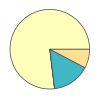

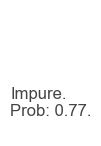

The index of the decision tree: 1



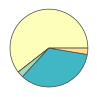

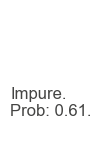

The index of the decision tree: 2



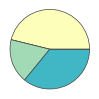

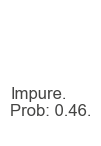

The index of the decision tree: 3



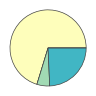

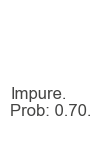

The index of the decision tree: 4



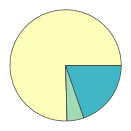

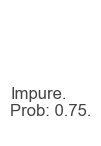

The index of the decision tree: 5



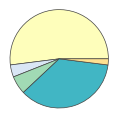

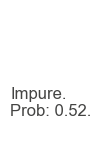

{'Rare': 0, 'Impure': 6}


In [17]:
# collecting images
analysis = {
    "Rare": 0,
    "Impure": 0,
}

    
for tree_index in range(num_of_trees):
    leaf_explainations = dict()
    cur_node_id = leaf_indices[0][tree_index]
    cur_tree = rf_small_entropy[tree_index]
    export_text_for_main_reasons(X_df, cur_tree, feature_names=list(X_df.columns), \
                                 class_names=target_names, show_weights=True, show_prob = True, crn_threshold=1.1)
    viz_model = model_with_only_main(cur_tree, X_df, Y,
                    target_name="target",
                    feature_names=list(X_df.columns),
                    class_names=target_names)

    # viz_model.ctree_leaf_distributions(display_type = "text")
    # viz_model.node_stats(node_id=10)
    v = viz_model.view()     # render as SVG into internal object 
print(analysis)

In [18]:
leaf_indices = rf_small_entropy.apply([X_df.iloc[2000]])
leaf_indices
print(X_df.iloc[2000])

GRD_SPD       454.00000
VTC_SPD        64.00000
DIS_TO_DES    413.89791
Name: 2000, dtype: float64


/Users/binshuaiwang/PycharmProjects/XAI_project/venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names


The index of the decision tree: 0



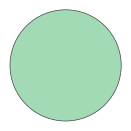

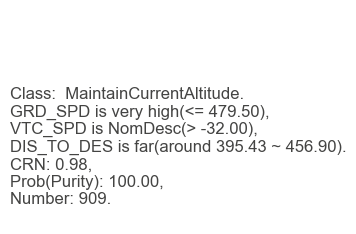

The index of the decision tree: 1



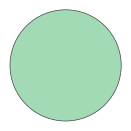

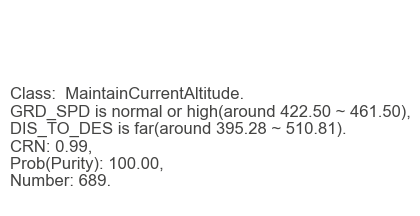

The index of the decision tree: 2



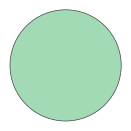

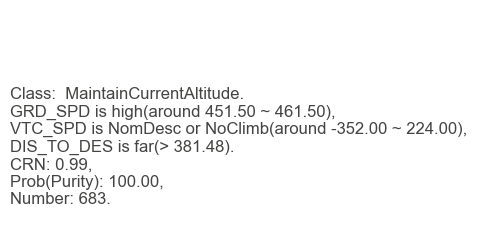

The index of the decision tree: 3



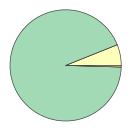

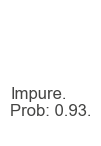

The index of the decision tree: 4



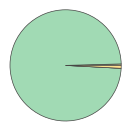

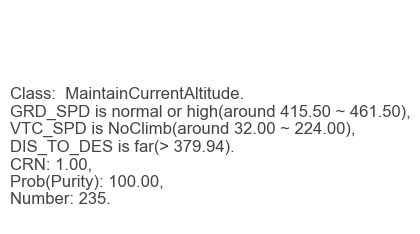

The index of the decision tree: 5



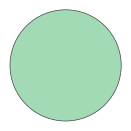

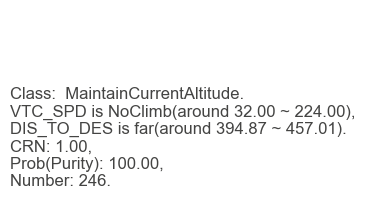

{'Rare': 0, 'Impure': 1, ' MaintainCurrentAltitude': 5}


In [19]:
# collecting images
analysis = {
    "Rare": 0,
    "Impure": 0,
}    
for tree_index in range(num_of_trees):
    leaf_explainations = dict()
    cur_node_id = leaf_indices[0][tree_index]
    cur_tree = rf_small_entropy[tree_index]
    export_text_for_main_reasons(X_df, cur_tree, feature_names=list(X_df.columns), \
                                 class_names=target_names, show_weights=True, show_prob = True, crn_threshold=1.1)
    viz_model = model_with_only_main(cur_tree, X_df, Y,
                    target_name="target",
                    feature_names=list(X_df.columns),
                    class_names=target_names)

    # viz_model.ctree_leaf_distributions(display_type = "text")
    # viz_model.node_stats(node_id=10)
    v = viz_model.view()     # render as SVG into internal object 
print(analysis)

In [20]:
leaf_indices = rf_small_entropy.apply([X_df.iloc[5000]])
leaf_indices
print(X_df.iloc[5000])

GRD_SPD       489.000000
VTC_SPD         0.000000
DIS_TO_DES    180.036193
Name: 5000, dtype: float64


/Users/binshuaiwang/PycharmProjects/XAI_project/venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names


The index of the decision tree: 0



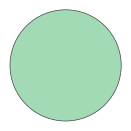

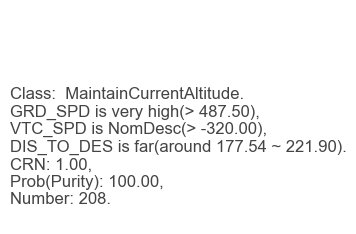

The index of the decision tree: 1



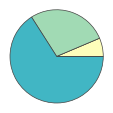

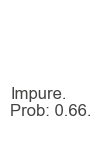

The index of the decision tree: 2



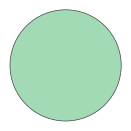

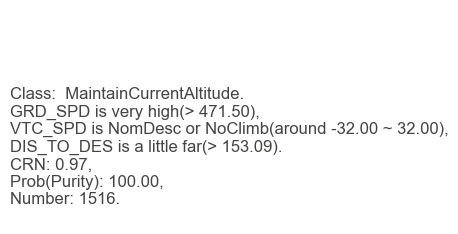

The index of the decision tree: 3



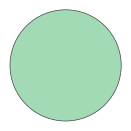

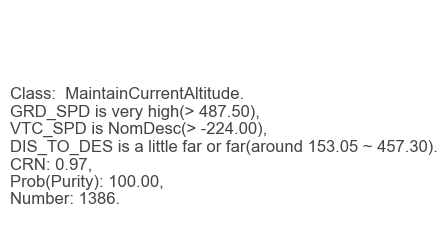

The index of the decision tree: 4



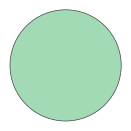

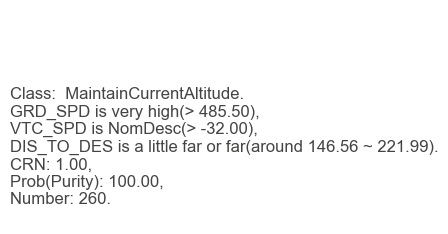

The index of the decision tree: 5



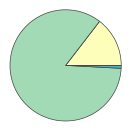

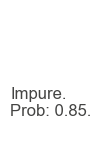

{'Rare': 0, 'Impure': 2, ' MaintainCurrentAltitude': 4}


In [21]:
# collecting images
analysis = {
    "Rare": 0,
    "Impure": 0,
}    
for tree_index in range(num_of_trees):
    leaf_explainations = dict()
    cur_node_id = leaf_indices[0][tree_index]
    cur_tree = rf_small_entropy[tree_index]
    export_text_for_main_reasons(X_df, cur_tree, feature_names=list(X_df.columns), \
                                 class_names=target_names, show_weights=True, show_prob = True, crn_threshold=1.1)
    viz_model = model_with_only_main(cur_tree, X_df, Y,
                    target_name="target",
                    feature_names=list(X_df.columns),
                    class_names=target_names)

    # viz_model.ctree_leaf_distributions(display_type = "text")
    # viz_model.node_stats(node_id=10)
    v = viz_model.view()     # render as SVG into internal object 
print(analysis)